# Projet: Prédiction de la demande énergétique

**IFT3395/IFT6390 - Fondements de l'apprentissage machine**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pierrelux/mlbook/blob/main/exercises/projet_energie.ipynb)

**Compétition Kaggle:** [Rejoindre la compétition](https://www.kaggle.com/t/72daeb9bff104caf912f9a0b0f42eb5a)

---

## Contexte

Hydro-Québec publie des données ouvertes sur la consommation électrique de clients participant à un programme de gestion de la demande. Ces données incluent la consommation horaire, les conditions météorologiques, et des indicateurs d'événements de pointe.

Votre mission: construire un modèle de prédiction de la consommation énergétique en utilisant **uniquement** les méthodes vues dans les chapitres 1 à 5 du cours.

## Objectifs d'apprentissage

À la fin de ce projet, vous serez en mesure de:

1. Implémenter les moindres carrés ordinaires (OLS) à partir de zéro
2. Implémenter la régression logistique avec descente de gradient
3. Appliquer la régularisation Ridge et interpréter ses effets
4. Construire un modèle à deux étages: classification → régression
5. Utiliser les probabilités prédites comme caractéristiques

## Évaluation

| Composante | Pondération | Description |
|------------|-------------|-------------|
| **Entrevue orale** | **60%** | Vérification de la compréhension |
| Code soumis | 20% | Complétion des parties 1-7 |
| Kaggle | 10% | Position au classement |
| Rapport écrit | 10% | Analyse et réflexion |

### Barème de l'entrevue orale (60%)

| Critère | Points | Ce qu'on évalue |
|---------|--------|-----------------|
| Dérivation OLS au tableau | 15 | Maîtrise de la solution analytique |
| Explication descente de gradient | 10 | Compréhension des mises à jour |
| Justification des choix | 15 | Pourquoi ces caractéristiques? Pourquoi TimeSeriesSplit? |
| Questions théoriques | 10 | Ridge = MAP, entropie croisée, etc. |
| Modifications en direct | 10 | Adapter le code et prédire les effets |

**Important**: L'entrevue orale est la composante principale de l'évaluation. Vous devez être capable d'expliquer et de justifier chaque ligne de code que vous soumettez.

### ⚠️ Avertissement sur l'utilisation d'outils IA

Les outils comme ChatGPT, Cursor, Copilot peuvent vous aider, **mais** :
- Vous devez comprendre **chaque ligne** de code que vous soumettez
- L'entrevue orale révélera rapidement si vous comprenez ou non
- **60% de la note** dépend de votre capacité à expliquer votre travail

**Conseil** : Utilisez ces outils pour apprendre, pas pour éviter d'apprendre. Du code copié sans compréhension mène à l'échec à l'entrevue orale.

---

## Partie 0: Configuration et chargement des données

Exécutez cette cellule pour importer les bibliothèques et charger les données.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

print("Configuration terminée!")

Configuration terminée!


### Chargement des données

Les données proviennent du jeu de données ouvert [consommation-clients-evenements-pointe](https://donnees.hydroquebec.com/explore/dataset/consommation-clients-evenements-pointe/) d'Hydro-Québec. Nous les chargeons directement depuis GitHub.

In [2]:
# URLs des données sur GitHub
BASE_URL = "https://raw.githubusercontent.com/pierrelux/mlbook/main/data/"

# Charger les données
print("Chargement des données depuis GitHub...")
train = pd.read_csv(BASE_URL + "energy_train.csv", parse_dates=['horodatage_local'])

# Pour l'évaluation locale: test avec la cible (energie_kwh)
test = pd.read_csv(BASE_URL + "energy_test_avec_cible.csv", parse_dates=['horodatage_local'])

# Pour Kaggle: test sans la cible (pour générer les prédictions)
test_kaggle = pd.read_csv(BASE_URL + "energy_test.csv", parse_dates=['horodatage_local'])

print(f"Ensemble d'entraînement: {len(train)} observations")
print(f"Ensemble de test: {len(test)} observations")
print(f"\nPériode d'entraînement: {train['horodatage_local'].min()} à {train['horodatage_local'].max()}")
print(f"Période de test: {test['horodatage_local'].min()} à {test['horodatage_local'].max()}")

Chargement des données depuis GitHub...
Ensemble d'entraînement: 8246 observations
Ensemble de test: 1754 observations

Période d'entraînement: 2022-01-01 05:00:00+00:00 à 2024-01-31 21:00:00+00:00
Période de test: 2024-02-01 01:00:00+00:00 à 2024-07-01 03:00:00+00:00


In [3]:
# Aperçu des données
print("Colonnes disponibles:")
print(train.columns.tolist())
print(f"\nProportion événements de pointe (train): {train['evenement_pointe'].mean():.1%}")
train.head()

Colonnes disponibles:
['horodatage_local', 'poste', 'heure', 'jour', 'mois', 'jour_semaine', 'temperature_ext', 'humidite', 'vitesse_vent', 'neige', 'irradiance_solaire', 'heure_sin', 'heure_cos', 'mois_sin', 'mois_cos', 'jour_semaine_sin', 'jour_semaine_cos', 'est_weekend', 'est_ferie', 'clients_connectes', 'tstats_intelligents_connectes', 'evenement_pointe', 'energie_kwh']

Proportion événements de pointe (train): 0.9%


horodatage_local poste  heure  jour  mois  jour_semaine  \
0 2022-01-01 05:00:00+00:00     A      0     1     1             7   
1 2022-01-01 06:00:00+00:00     A      1     1     1             7   
2 2022-01-01 07:00:00+00:00     C      2     1     1             7   
3 2022-01-01 08:00:00+00:00     A      3     1     1             7   
4 2022-01-01 11:00:00+00:00     A      6     1     1             7   

   temperature_ext  humidite  vitesse_vent  neige  ...  mois_sin  mois_cos  \
0             -1.2        92           0.5    0.0  ...       0.5  0.866025   
1             -1.3        93           1.0    0.0  ...       0.5  0.866025   
2             -1.2        93           1.0    0.0  ...       0.5  0.866025   
3             -1.2        94           1.0    0.0  ...       0.5  0.866025   
4             -1.0        97           1.5    0.0  ...       0.5  0.866025   

   jour_semaine_sin  jour_semaine_cos  est_weekend  est_ferie  \
0     -2.450000e-16               1.0            1          1   
1     -2.450000e-16               1.0            1          1   
2     -2.450000e-16               1.0            1          1   
3     -2.450000e-16               1.0            1          1   
4     -2.450000e-16               1.0            1          1   

   clients_connectes  tstats_intelligents_connectes  evenement_pointe  \
0                 17                            118                 0   
1                 17                            118                 0   
2                 35                            220                 0   
3                 17                            118                 0   
4                 17                            118                 0   

   energie_kwh  
0    60.931664  
1    59.117008  
2   142.911665  
3    52.323657  
4    78.351166  

[5 rows x 23 columns]

### Description des variables

Les données contiennent des mesures météorologiques et temporelles pour prédire la consommation énergétique.

In [4]:
# Description des variables
print("Variables météorologiques:")
print("  - temperature_ext: Température extérieure moyenne (°C)")
print("  - humidite: Humidité relative moyenne (%)")
print("  - vitesse_vent: Vitesse du vent moyenne (km/h)")
print("  - neige: Précipitations de neige moyennes")
print("  - irradiance_solaire: Irradiance solaire moyenne")

print("\nVariables temporelles:")
print("  - heure, mois, jour, jour_semaine: Composantes temporelles")
print("  - heure_sin, heure_cos, mois_sin, mois_cos: Encodage cyclique")
print("  - est_weekend, est_ferie: Indicateurs binaires")

print("\nAutres:")
print("  - evenement_pointe: Indicateur d'événement de pointe (classification)")
print("  - energie_kwh: Variable cible (consommation en kWh)")

print(f"\nStatistiques de base:")
train[['temperature_ext', 'humidite', 'energie_kwh']].describe()

Variables météorologiques:
  - temperature_ext: Température extérieure moyenne (°C)
  - humidite: Humidité relative moyenne (%)
  - vitesse_vent: Vitesse du vent moyenne (km/h)
  - neige: Précipitations de neige moyennes
  - irradiance_solaire: Irradiance solaire moyenne

Variables temporelles:
  - heure, mois, jour, jour_semaine: Composantes temporelles
  - heure_sin, heure_cos, mois_sin, mois_cos: Encodage cyclique
  - est_weekend, est_ferie: Indicateurs binaires

Autres:
  - evenement_pointe: Indicateur d'événement de pointe (classification)
  - energie_kwh: Variable cible (consommation en kWh)

Statistiques de base:


temperature_ext     humidite   energie_kwh
count      8246.000000  8246.000000   8246.000000
mean          5.982573    72.964831    215.906679
std          12.722433    18.063945    212.948127
min         -32.000000    16.000000     13.007400
25%          -2.600000    60.000000     90.226631
50%           5.300000    76.000000    169.503467
75%          17.000000    88.000000    294.907806
max          33.000000   100.000000  11804.198070

In [5]:
# IMPORTANT: Division temporelle déjà effectuée
# Les données de test couvrent la période à partir du 1er février 2024
# NE PAS mélanger les données - c'est une série temporelle!

print("⚠️  ATTENTION: Division temporelle")
print("Les ensembles train/test sont déjà séparés chronologiquement.")
print("N'utilisez PAS de validation croisée aléatoire (fuite d'information).")
print("\nPour la validation, utilisez une division temporelle sur train:")
print("  - Ex: train[:6000] pour entraînement, train[6000:] pour validation")

# Note: il y a un décalage de distribution entre train (hiver) et test (printemps/été)
# C'est un défi réaliste! Pensez à utiliser des caractéristiques qui généralisent bien.
print("\n📊 Décalage de distribution:")
print(f"  Train: {train['energie_kwh'].mean():.1f} kWh (hiver)")
print(f"  Test:  {test['energie_kwh'].mean():.1f} kWh (printemps/été)")
print("  → Le modèle doit généraliser à travers les saisons!")

⚠️  ATTENTION: Division temporelle
Les ensembles train/test sont déjà séparés chronologiquement.
N'utilisez PAS de validation croisée aléatoire (fuite d'information).

Pour la validation, utilisez une division temporelle sur train:
  - Ex: train[:6000] pour entraînement, train[6000:] pour validation

📊 Décalage de distribution:
  Train: 215.9 kWh (hiver)
  Test:  83.7 kWh (printemps/été)
  → Le modèle doit généraliser à travers les saisons!


### Exploration visuelle

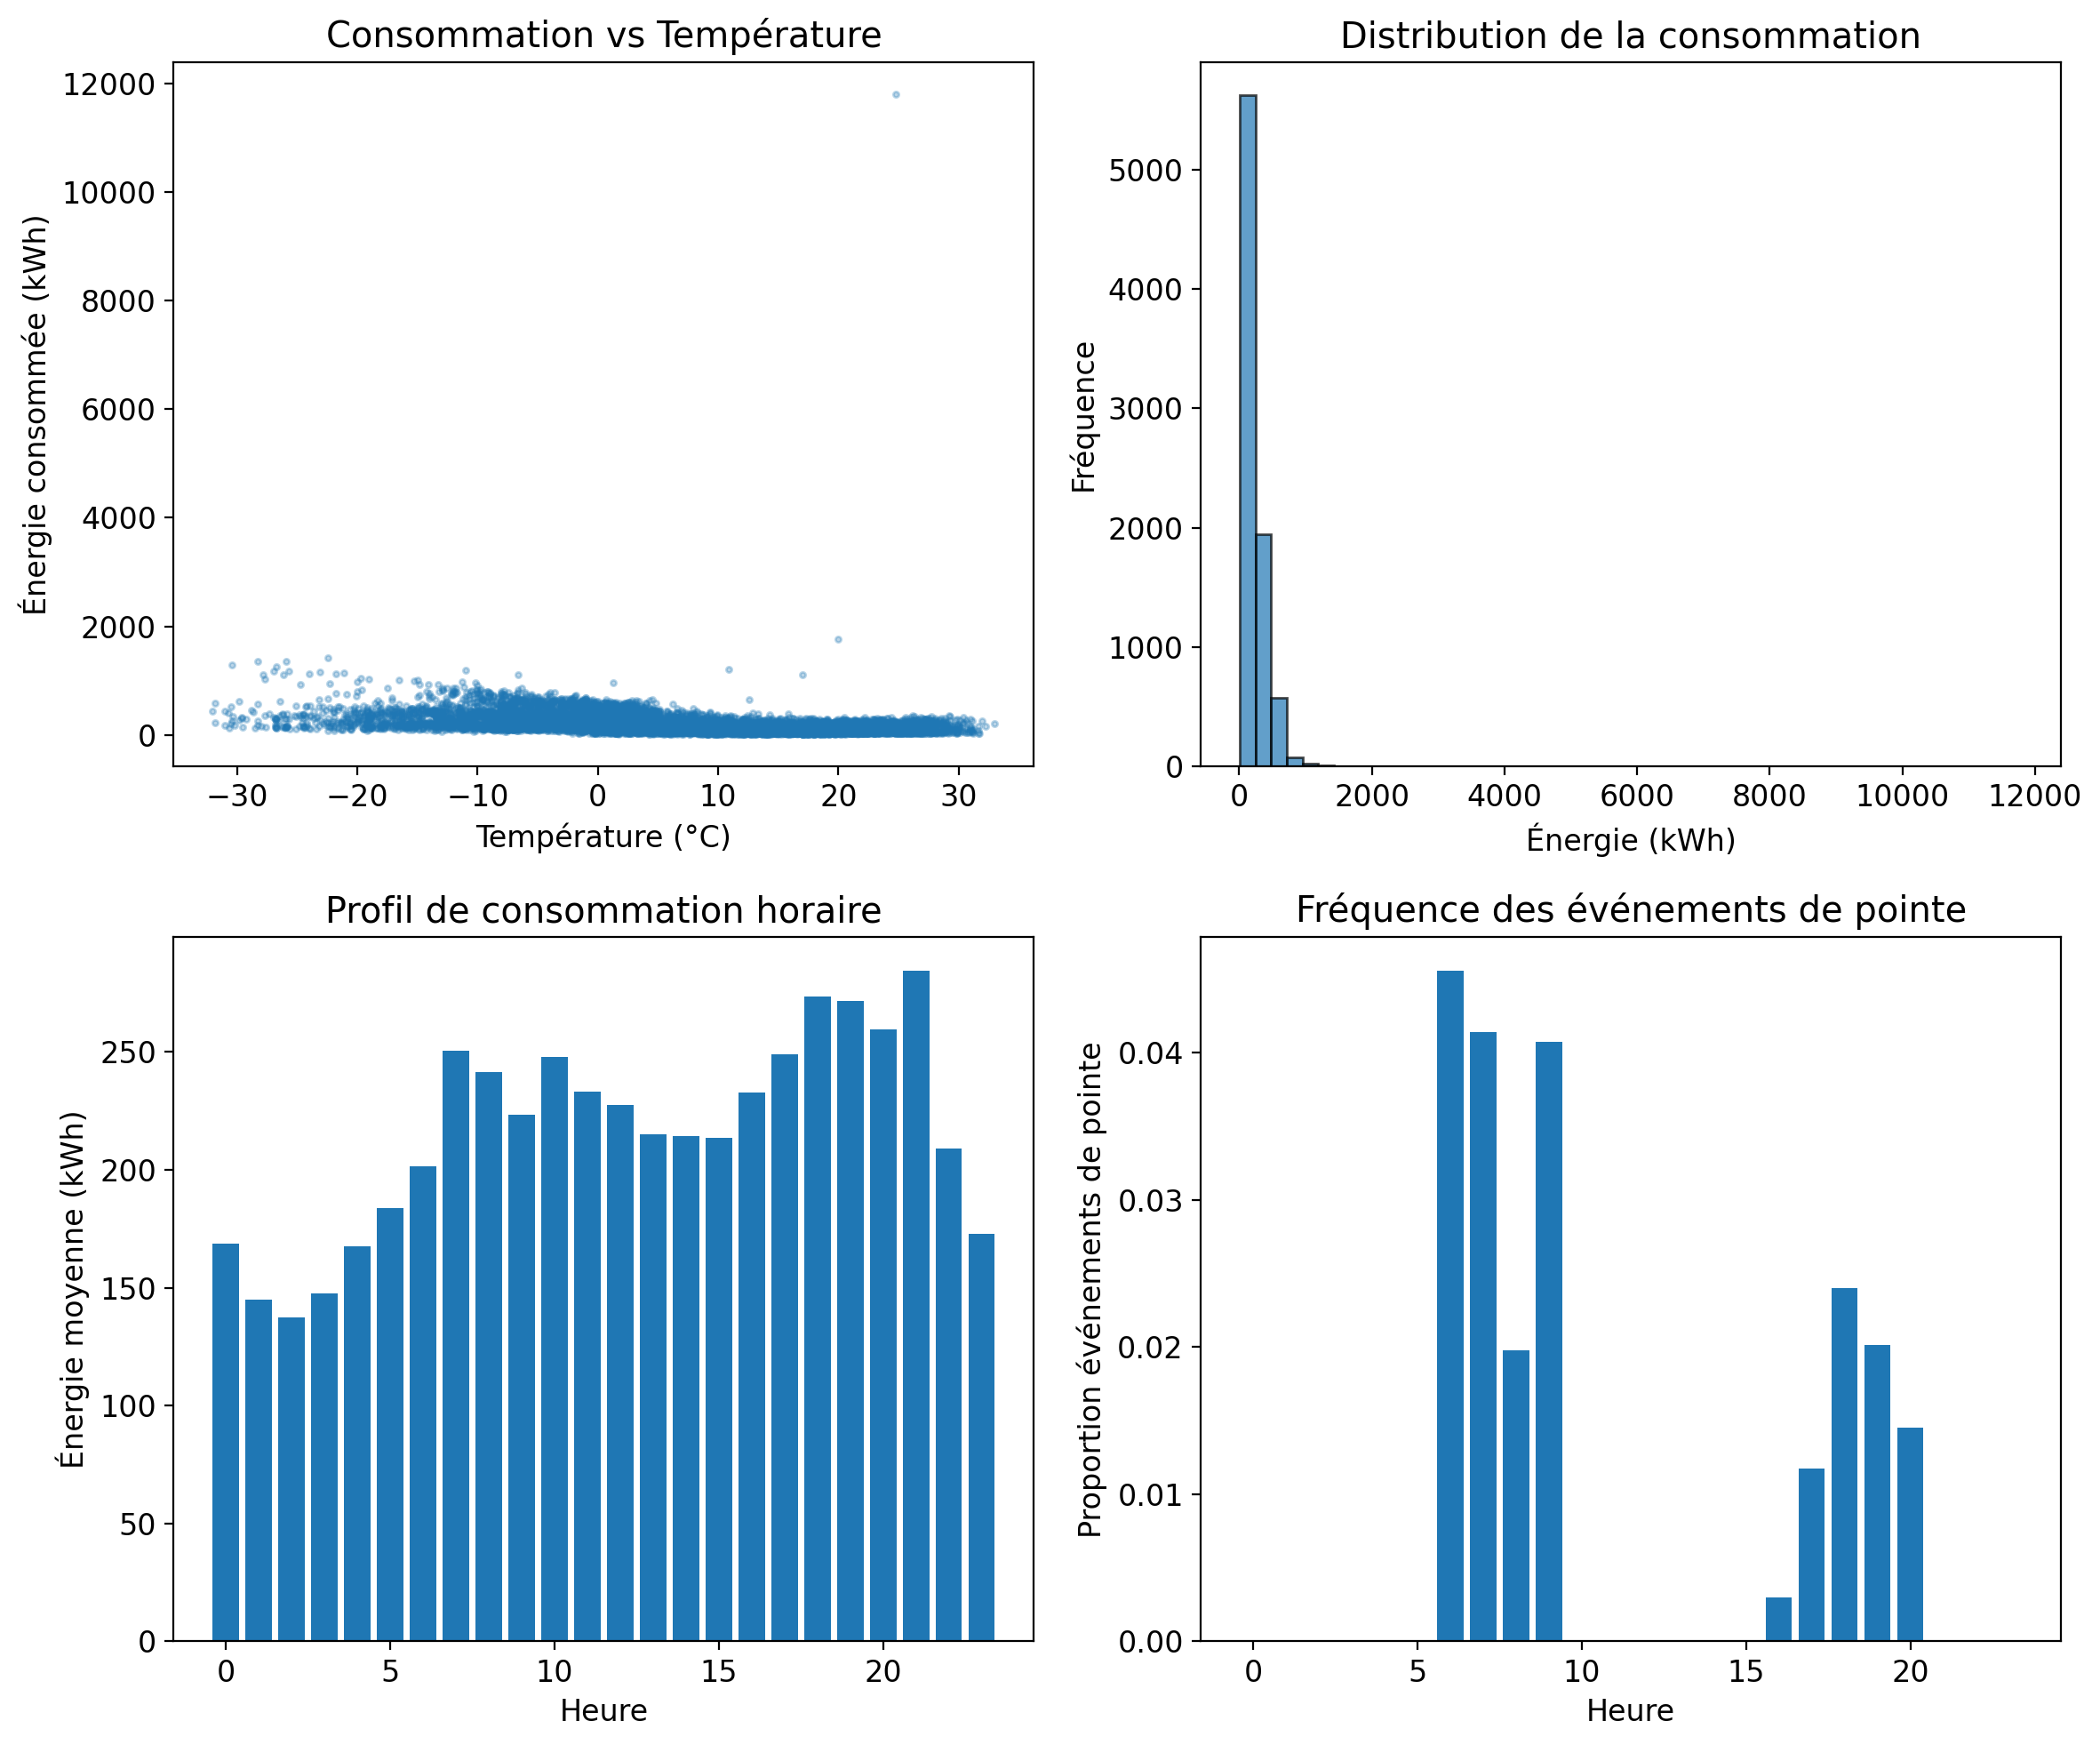

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Consommation vs température
axes[0, 0].scatter(train['temperature_ext'], train['energie_kwh'], alpha=0.3, s=5)
axes[0, 0].set_xlabel('Température (°C)')
axes[0, 0].set_ylabel('Énergie consommée (kWh)')
axes[0, 0].set_title('Consommation vs Température')

# Distribution de la consommation
axes[0, 1].hist(train['energie_kwh'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Énergie (kWh)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution de la consommation')

# Profil horaire
profil_horaire = train.groupby('heure')['energie_kwh'].mean()
axes[1, 0].bar(profil_horaire.index, profil_horaire.values)
axes[1, 0].set_xlabel('Heure')
axes[1, 0].set_ylabel('Énergie moyenne (kWh)')
axes[1, 0].set_title('Profil de consommation horaire')

# Événements de pointe par heure
pointe_horaire = train.groupby('heure')['evenement_pointe'].mean()
axes[1, 1].bar(pointe_horaire.index, pointe_horaire.values)
axes[1, 1].set_xlabel('Heure')
axes[1, 1].set_ylabel('Proportion événements de pointe')
axes[1, 1].set_title('Fréquence des événements de pointe')

plt.tight_layout()

ANALYSE STATISTIQUE DÉTAILLÉE


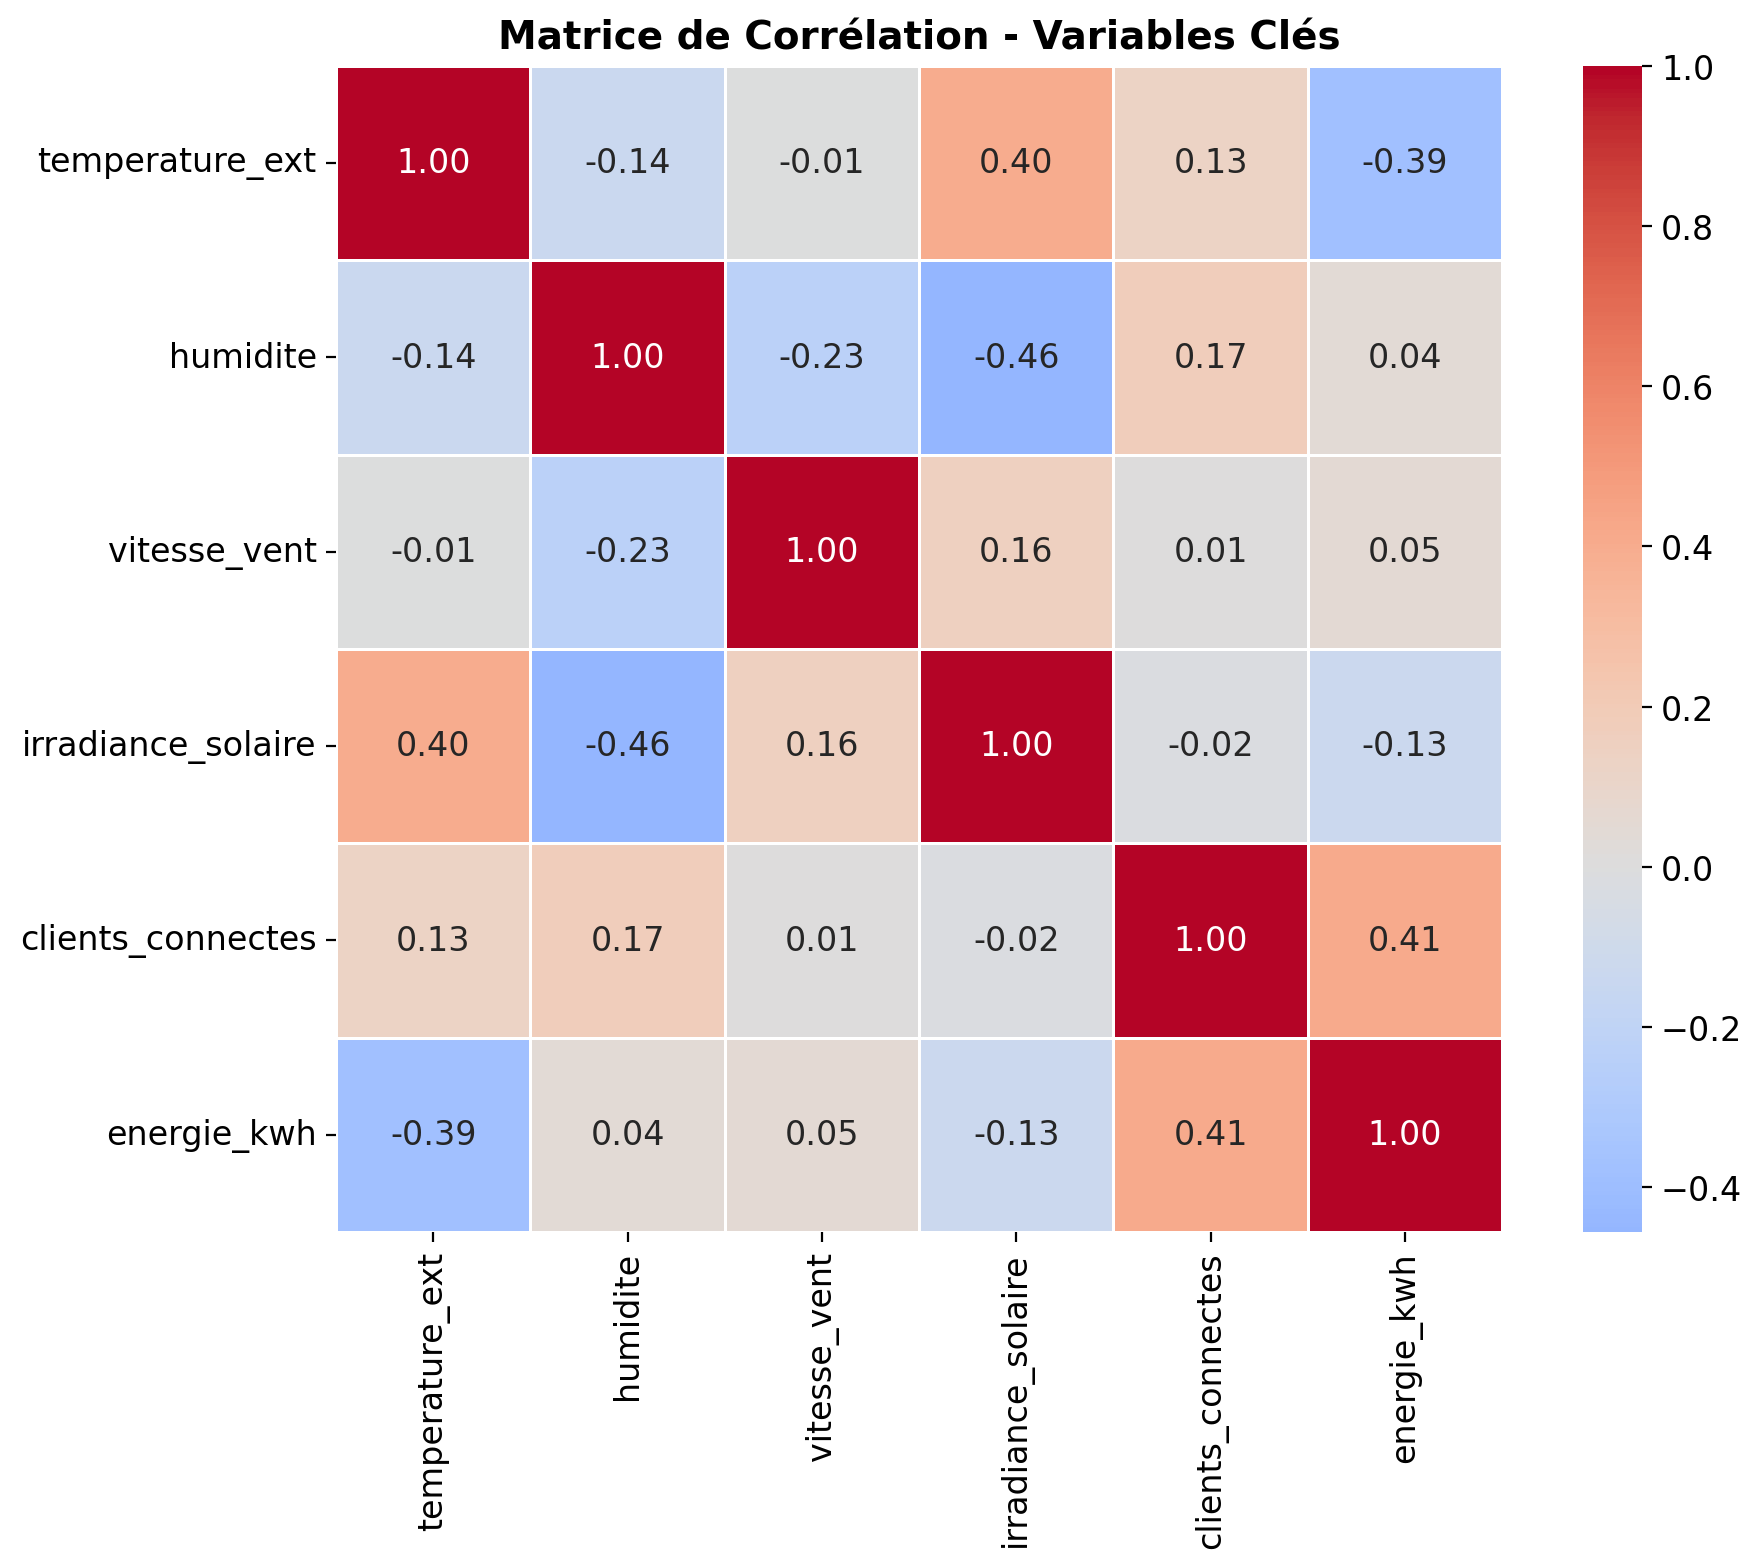


Top 5 corrélations avec energie_kwh:
clients_connectes     0.409159
vitesse_vent          0.053169
humidite              0.042872
irradiance_solaire   -0.129996
temperature_ext      -0.387236
Name: energie_kwh, dtype: float64


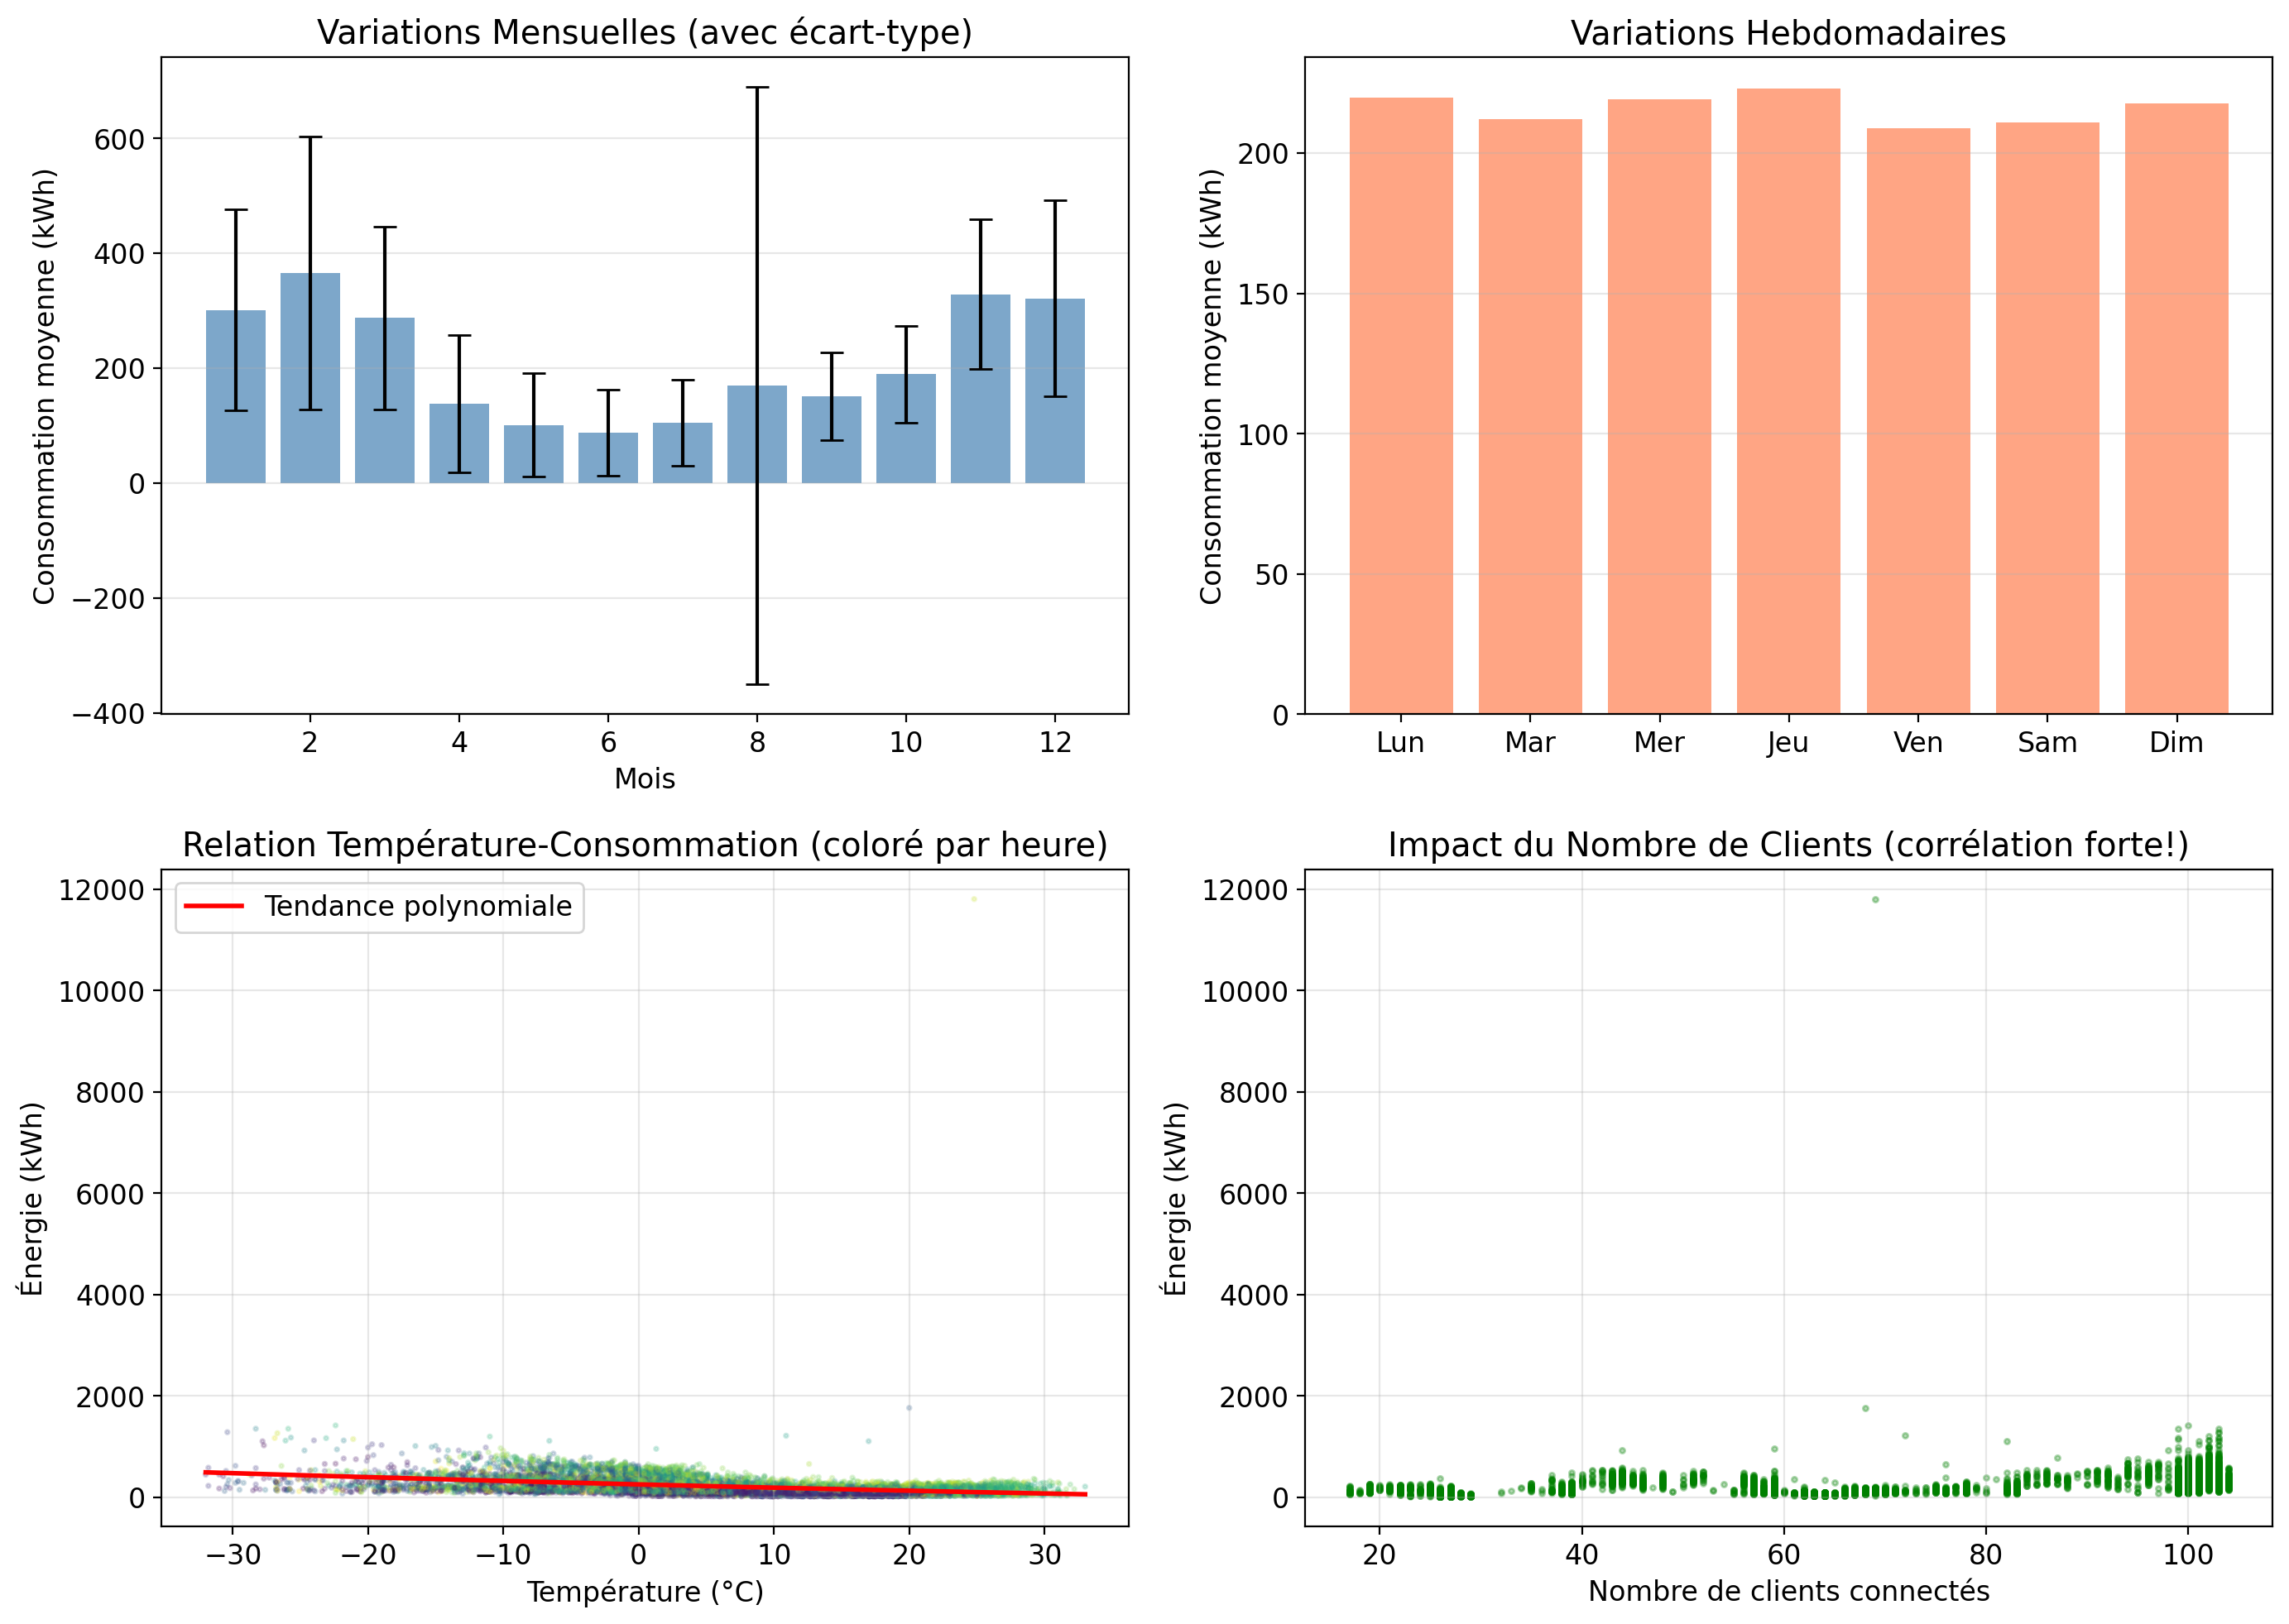


ANALYSE DES ÉVÉNEMENTS DE POINTE

Statistiques consommation par type:
                   count        mean         std        min         25%  \
evenement_pointe                                                          
0                 8168.0  215.452212  213.169329  13.007400   89.595401   
1                   78.0  263.497524  183.363452  53.978378  148.211377   

                         50%         75%           max  
evenement_pointe                                        
0                 168.974705  293.796942  11804.198070  
1                 197.466547  327.388245    828.184795  

Ratio consommation pointe/normal: 1.22x


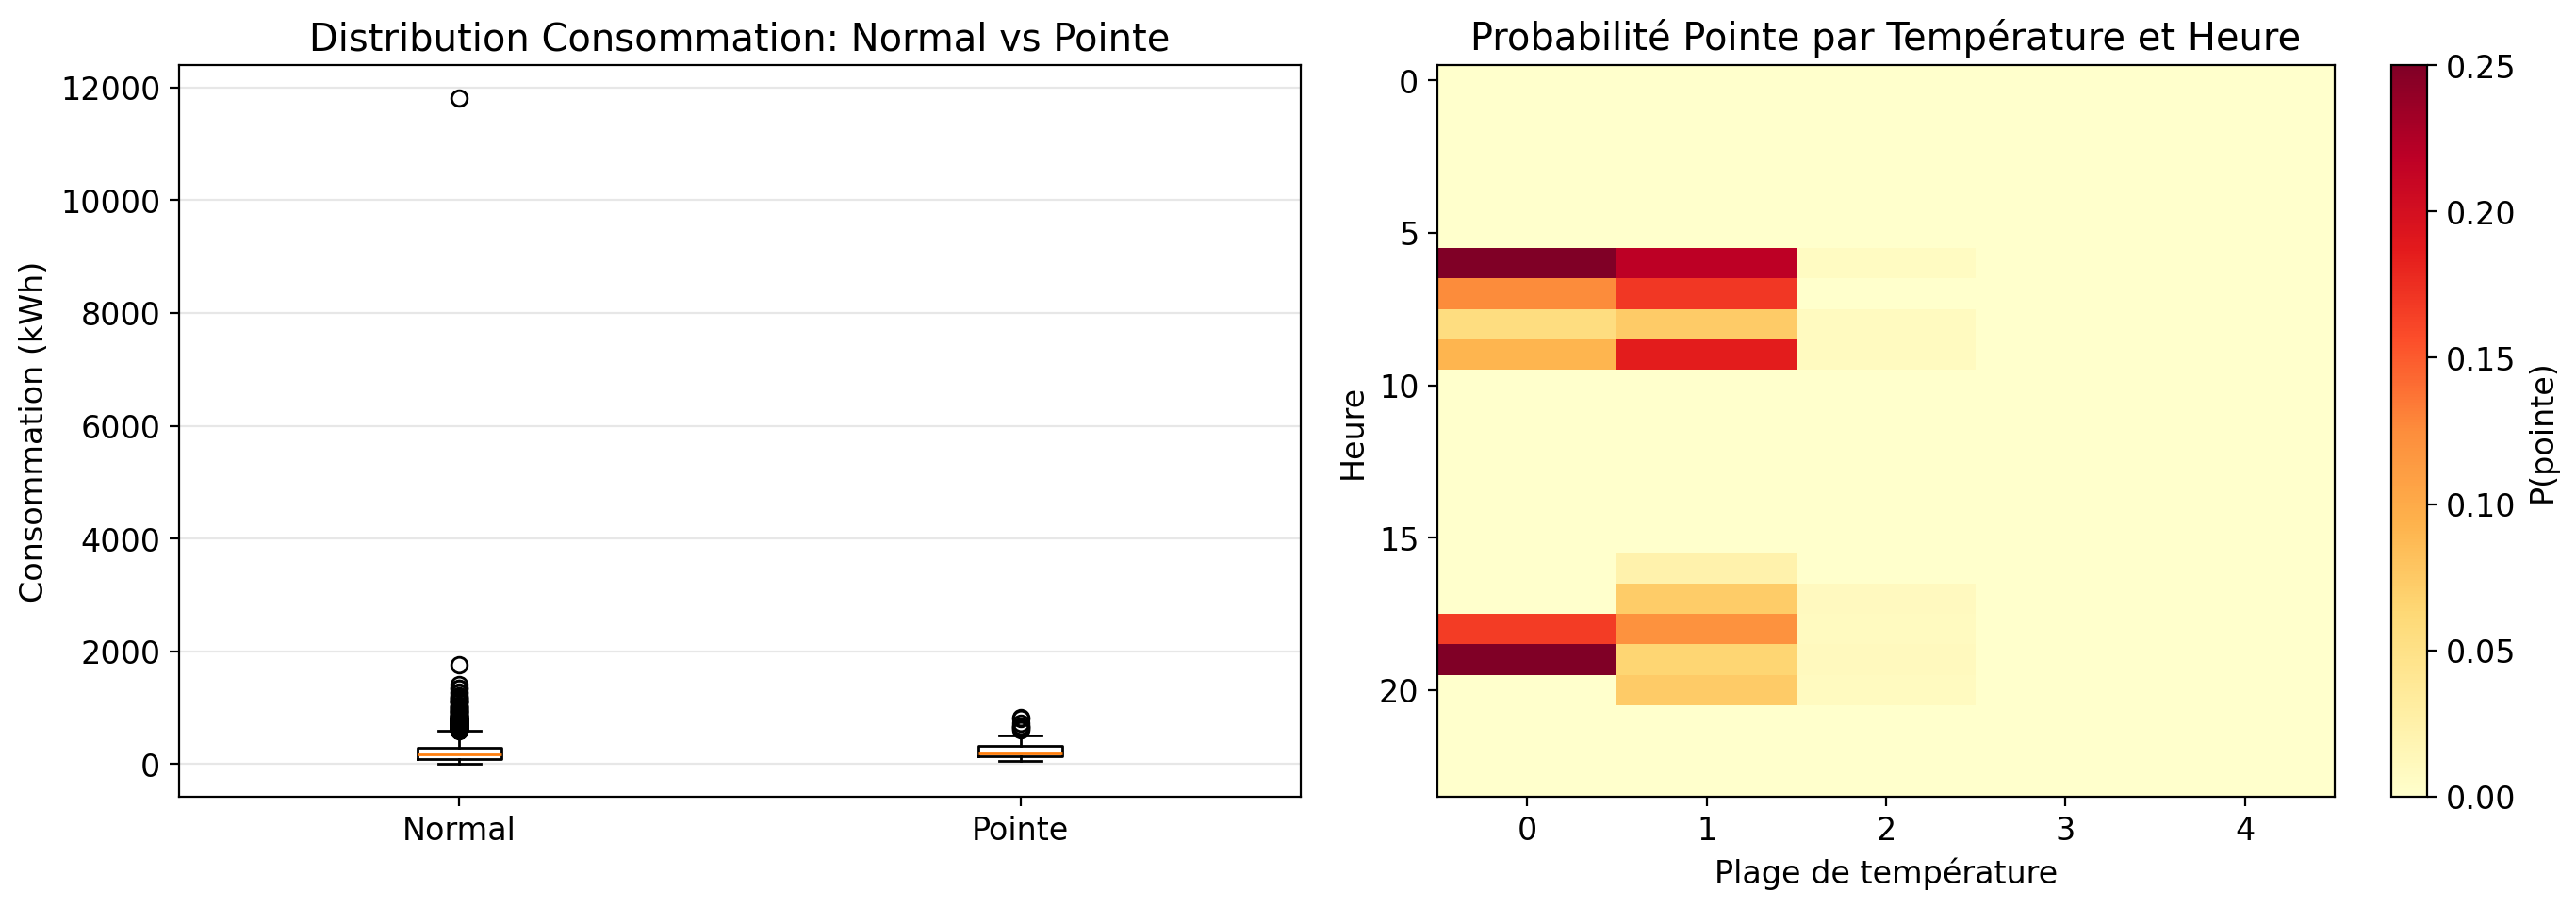


ANALYSE DÉCALAGE TRAIN/TEST
   Variable  Train (moyenne)  Test (moyenne)  Écart (%)
Température         5.982573        9.507241  58.915570
   Humidité        72.964831       73.371722   0.557653
       Vent         2.635353        2.954875  12.124438
    Énergie       215.906679       83.735566 -61.216778
 Pointe (%)         0.945913        1.596351  68.762974

Observation: Le décalage train/test est significatif!
Stratégie: Utiliser features qui généralisent bien (degré-jours, etc.)


In [7]:
# ============================================
# ANALYSE EXPLORATOIRE APPROFONDIE
# ============================================
import seaborn as sns

print("="*60)
print("ANALYSE STATISTIQUE DÉTAILLÉE")
print("="*60)

# 1. Matrice de corrélation des variables principales
features_corr = ['temperature_ext', 'humidite', 'vitesse_vent', 
                 'irradiance_solaire', 'clients_connectes', 'energie_kwh']

corr_matrix = train[features_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Matrice de Corrélation - Variables Clés', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 5 corrélations avec energie_kwh:")
corr_with_target = corr_matrix['energie_kwh'].sort_values(ascending=False)[1:6]
print(corr_with_target)


# 2. Distribution par saison et jour de la semaine
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Consommation par mois
monthly_stats = train.groupby('mois')['energie_kwh'].agg(['mean', 'std'])
axes[0, 0].bar(monthly_stats.index, monthly_stats['mean'], 
               yerr=monthly_stats['std'], capsize=5, alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Mois')
axes[0, 0].set_ylabel('Consommation moyenne (kWh)')
axes[0, 0].set_title('Variations Mensuelles (avec écart-type)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Consommation par jour de la semaine
weekly_stats = train.groupby('jour_semaine')['energie_kwh'].mean()
days = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
axes[0, 1].bar(range(7), weekly_stats, color='coral', alpha=0.7)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_ylabel('Consommation moyenne (kWh)')
axes[0, 1].set_title('Variations Hebdomadaires')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Température vs Consommation (avec régression)
axes[1, 0].scatter(train['temperature_ext'], train['energie_kwh'], 
                   alpha=0.2, s=3, c=train['heure'], cmap='viridis')
# Ajouter courbe de tendance
z = np.polyfit(train['temperature_ext'], train['energie_kwh'], 2)
p = np.poly1d(z)
temp_range = np.linspace(train['temperature_ext'].min(), 
                         train['temperature_ext'].max(), 100)
axes[1, 0].plot(temp_range, p(temp_range), 'r-', linewidth=2, 
                label='Tendance polynomiale')
axes[1, 0].set_xlabel('Température (°C)')
axes[1, 0].set_ylabel('Énergie (kWh)')
axes[1, 0].set_title('Relation Température-Consommation (coloré par heure)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# clients_connectes vs energie_kwh (très important!)
axes[1, 1].scatter(train['clients_connectes'], train['energie_kwh'], 
                   alpha=0.3, s=5, c='green')
axes[1, 1].set_xlabel('Nombre de clients connectés')
axes[1, 1].set_ylabel('Énergie (kWh)')
axes[1, 1].set_title('Impact du Nombre de Clients (corrélation forte!)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 3. Analyse des événements de pointe
print("\n" + "="*60)
print("ANALYSE DES ÉVÉNEMENTS DE POINTE")
print("="*60)

pointe_stats = train.groupby('evenement_pointe')['energie_kwh'].describe()
print("\nStatistiques consommation par type:")
print(pointe_stats)

print(f"\nRatio consommation pointe/normal: "
      f"{pointe_stats.loc[1, 'mean'] / pointe_stats.loc[0, 'mean']:.2f}x")

# Boxplot comparatif
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot([train[train['evenement_pointe']==0]['energie_kwh'],
                 train[train['evenement_pointe']==1]['energie_kwh']],
                labels=['Normal', 'Pointe'])
axes[0].set_ylabel('Consommation (kWh)')
axes[0].set_title('Distribution Consommation: Normal vs Pointe')
axes[0].grid(True, alpha=0.3, axis='y')

# Heures de pointe par température
temp_bins = pd.cut(train['temperature_ext'], bins=5)
pointe_by_temp = train.groupby([temp_bins, 'heure'])['evenement_pointe'].mean().unstack()

im = axes[1].imshow(pointe_by_temp.T, cmap='YlOrRd', aspect='auto')
axes[1].set_xlabel('Plage de température')
axes[1].set_ylabel('Heure')
axes[1].set_title('Probabilité Pointe par Température et Heure')
plt.colorbar(im, ax=axes[1], label='P(pointe)')

plt.tight_layout()
plt.show()


# 4. Test de stationnarité (décalage train/test)
print("\n" + "="*60)
print("ANALYSE DÉCALAGE TRAIN/TEST")
print("="*60)

comparison = pd.DataFrame({
    'Variable': ['Température', 'Humidité', 'Vent', 'Énergie', 'Pointe (%)'],
    'Train (moyenne)': [
        train['temperature_ext'].mean(),
        train['humidite'].mean(),
        train['vitesse_vent'].mean(),
        train['energie_kwh'].mean(),
        train['evenement_pointe'].mean()*100
    ],
    'Test (moyenne)': [
        test['temperature_ext'].mean(),
        test['humidite'].mean(),
        test['vitesse_vent'].mean(),
        test['energie_kwh'].mean(),
        test['evenement_pointe'].mean()*100
    ]
})
comparison['Écart (%)'] = 100 * (comparison['Test (moyenne)'] - 
                                  comparison['Train (moyenne)']) / comparison['Train (moyenne)']

print(comparison.to_string(index=False))
print("\nObservation: Le décalage train/test est significatif!")
print("Stratégie: Utiliser features qui généralisent bien (degré-jours, etc.)")

---

## Partie 1: Implémentation OLS (10%)

Avant d'utiliser scikit-learn, vous devez implémenter la solution analytique des moindres carrés ordinaires.

**Rappel**: La solution OLS est donnée par:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}$$

Pour des raisons de stabilité numérique, préférez `np.linalg.solve` à l'inversion directe.

In [8]:
def ols_fit(X, y):
    """
    Calcule les coefficients OLS.
    
    Paramètres:
        X : ndarray de forme (n, p) - matrice de caractéristiques (SANS colonne de 1)
        y : ndarray de forme (n,) - vecteur cible
    
    Retourne:
        beta : ndarray de forme (p+1,) - coefficients [intercept, coef1, coef2, ...]
    
    Indice: Ajoutez une colonne de 1 à X pour l'intercept.
    """
    # VOTRE CODE ICI
    # 1. Ajouter une colonne de 1 pour l'intercept
    n = X.shape[0]
    X_with_intercept = np.column_stack((np.ones(n), X))
    # 2. Résoudre le système X^T X beta = X^T y
    XTX = X_with_intercept.T @ X_with_intercept
    XTy = X_with_intercept.T @ y
    # 3. Retourner beta
    beta = np.linalg.solve(XTX, XTy)
    return beta    


def ols_predict(X, beta):
    """
    Prédit avec les coefficients OLS.
    
    Paramètres:
        X : ndarray de forme (n, p) - caractéristiques (SANS colonne de 1)
        beta : ndarray de forme (p+1,) - coefficients [intercept, coef1, ...]
    
    Retourne:
        y_pred : ndarray de forme (n,)
    """
    # VOTRE CODE ICI
    n = X.shape[0]
    X_with_intercept = np.column_stack((np.ones(n), X))
    y_pred = X_with_intercept @ beta
    return y_pred

In [9]:
# Test de votre implémentation
# Caractéristiques simples pour commencer
features_base = ['temperature_ext', 'humidite', 'vitesse_vent']

X_train_base = train[features_base].values
y_train = train['energie_kwh'].values
X_test_base = test[features_base].values
y_test = test['energie_kwh'].values

# Votre implémentation
beta_ols = ols_fit(X_train_base, y_train)
y_pred_ols = ols_predict(X_test_base, beta_ols)

# Validation avec sklearn
model_sklearn = LinearRegression()
model_sklearn.fit(X_train_base, y_train)
y_pred_sklearn = model_sklearn.predict(X_test_base)

# Comparaison
print("Comparaison OLS implémenté vs sklearn:")
print(f"  Intercept - Vous: {beta_ols[0]:.4f}, sklearn: {model_sklearn.intercept_:.4f}")
print(f"  Coefficients proches: {np.allclose(beta_ols[1:], model_sklearn.coef_, atol=1e-4)}")
print(f"\nR² sur test: {r2_score(y_test, y_pred_ols):.4f}")

Comparaison OLS implémenté vs sklearn:
  Intercept - Vous: 234.8557, sklearn: 234.8557
  Coefficients proches: True

R² sur test: -2.2572



DIAGNOSTIQUES OLS


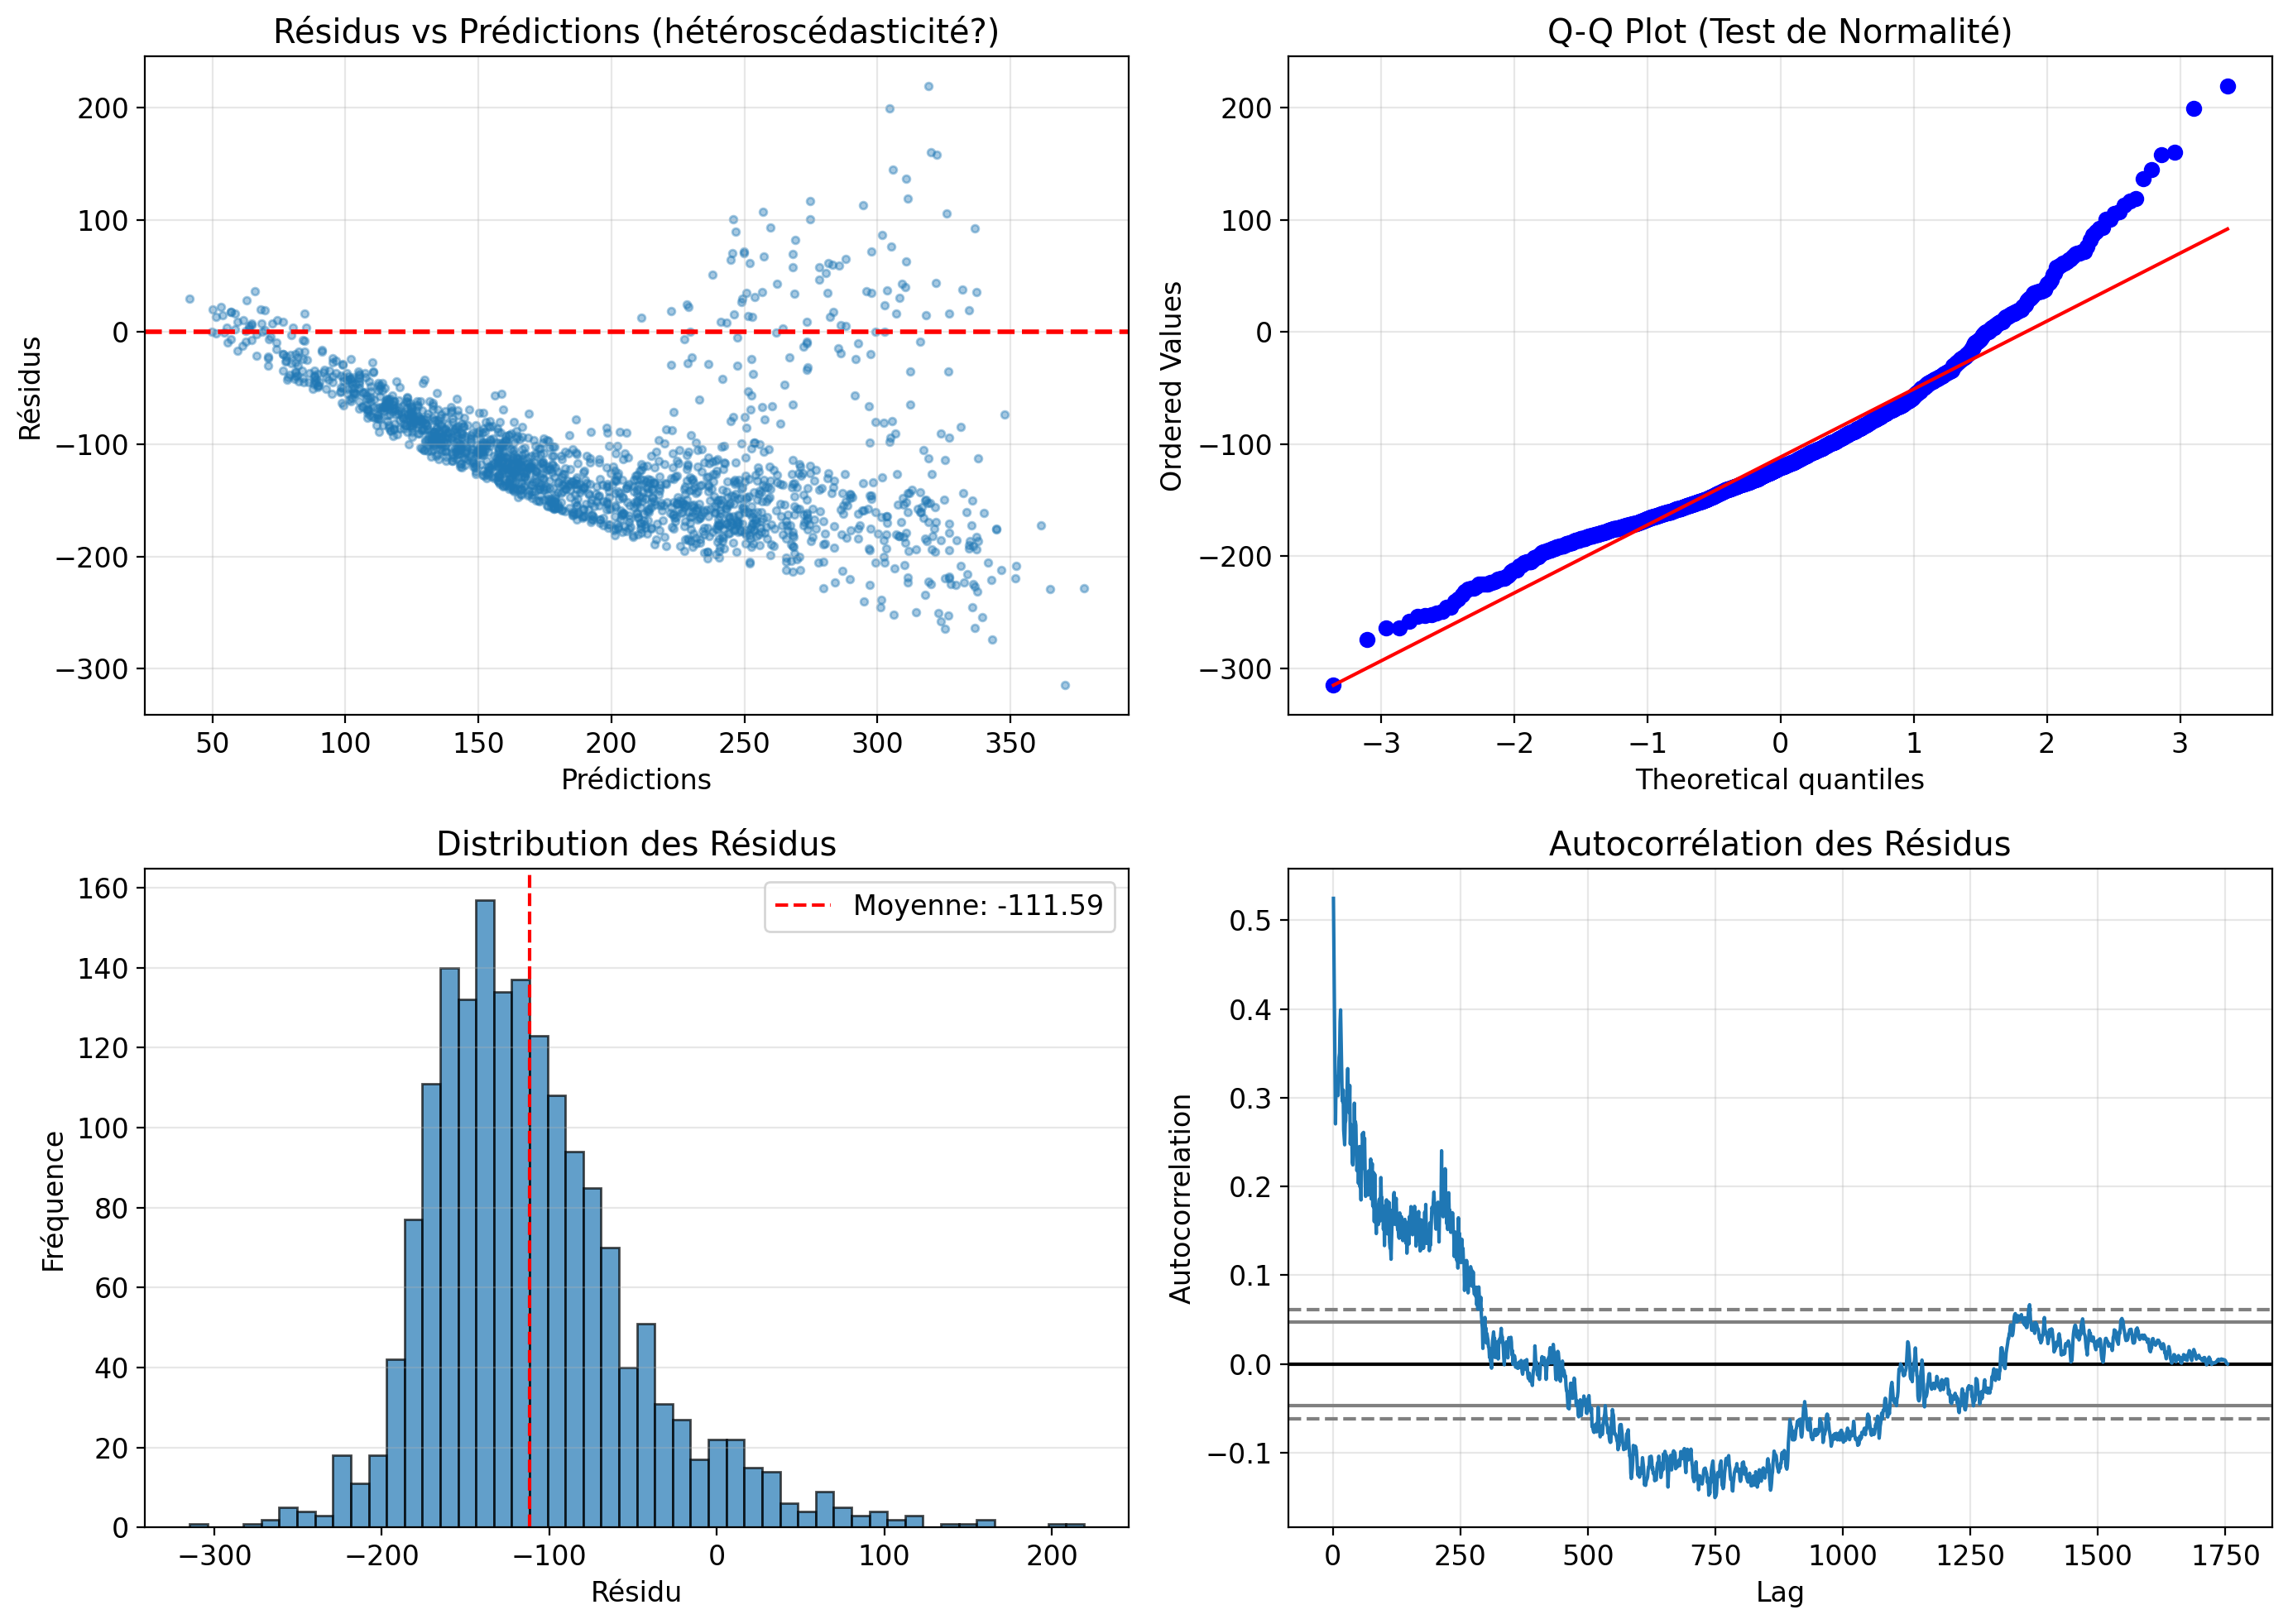


Statistiques résidus:
  Moyenne: -111.5928 (devrait être ~0)
  Écart-type: 62.07
  Min: -314.65, Max: 219.22
  Test Shapiro-Wilk: p-value = 0.0000
    → Résidus NON normaux (mais OK pour grandes données)

INTERPRÉTATION DES COEFFICIENTS OLS
        Feature  Coefficient  |Coefficient|
   vitesse_vent     6.971936       6.971936
temperature_ext    -6.472603       6.472603
       humidite     0.019192       0.019192

Intercept: 234.86 kWh

Interprétation exemple:
  - temperature_ext: coefficient = -6.47
    → +1°C → -6.47 kWh de consommation


In [10]:
# CELLULE À AJOUTER - Diagnostiques OLS

print("\n" + "="*60)
print("DIAGNOSTIQUES OLS")
print("="*60)

# 1. Analyse des résidus
residus_ols = y_test - y_pred_ols

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Résidus vs prédictions
axes[0, 0].scatter(y_pred_ols, residus_ols, alpha=0.4, s=10)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prédictions')
axes[0, 0].set_ylabel('Résidus')
axes[0, 0].set_title('Résidus vs Prédictions (hétéroscédasticité?)')
axes[0, 0].grid(True, alpha=0.3)

# QQ-plot (normalité des résidus)
from scipy import stats
stats.probplot(residus_ols, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Test de Normalité)')
axes[0, 1].grid(True, alpha=0.3)

# Histogramme résidus
axes[1, 0].hist(residus_ols, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(residus_ols.mean(), color='red', linestyle='--',
                   label=f'Moyenne: {residus_ols.mean():.2f}')
axes[1, 0].set_xlabel('Résidu')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des Résidus')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Autocorrélation des résidus (important pour séries temporelles!)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(pd.Series(residus_ols), ax=axes[1, 1])
axes[1, 1].set_title('Autocorrélation des Résidus')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tests statistiques
print(f"\nStatistiques résidus:")
print(f"  Moyenne: {residus_ols.mean():.4f} (devrait être ~0)")
print(f"  Écart-type: {residus_ols.std():.2f}")
print(f"  Min: {residus_ols.min():.2f}, Max: {residus_ols.max():.2f}")

# Test de Shapiro-Wilk (normalité)
if len(residus_ols) < 5000:  # Limitation du test
    stat, p_value = stats.shapiro(residus_ols[:5000])
    print(f"  Test Shapiro-Wilk: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("    → Résidus NON normaux (mais OK pour grandes données)")

# 2. Coefficients OLS
print(f"\n{'='*60}")
print("INTERPRÉTATION DES COEFFICIENTS OLS")
print("="*60)

coef_df = pd.DataFrame({
    'Feature': features_base,
    'Coefficient': beta_ols[1:],
    '|Coefficient|': np.abs(beta_ols[1:])
}).sort_values('|Coefficient|', ascending=False)

print(coef_df.to_string(index=False))

print(f"\nIntercept: {beta_ols[0]:.2f} kWh")
print("\nInterprétation exemple:")
print(f"  - {features_base[0]}: coefficient = {beta_ols[1]:.2f}")
print(f"    → +1°C → {beta_ols[1]:+.2f} kWh de consommation")

---

## Partie 2: Régression logistique avec descente de gradient (15%)

Implémentez la régression logistique pour la classification binaire.

**Rappels**:
- Fonction sigmoïde: $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Perte d'entropie croisée: $L = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1-y_i) \log(1-p_i) \right]$
- Gradient: $\nabla L = \frac{1}{n} \mathbf{X}^\top (\sigma(\mathbf{X}\boldsymbol{\beta}) - \mathbf{y})$

In [11]:
def sigmoid(z):
    """
    Fonction sigmoïde.
    
    Indice: Pour la stabilité numérique, clip z entre -500 et 500.
    """
    # VOTRE CODE ICI
    z_clipped = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z_clipped))

def cross_entropy_loss(y_true, y_pred_proba):
    """
    Calcule la perte d'entropie croisée binaire.
    
    Indice: Clip les probabilités pour éviter log(0).
    """
    # VOTRE CODE ICI
    epsilon = 1e-15
    y_pred_proba_clipped = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_pred_proba_clipped) + (1 - y_true) * np.log(1 - y_pred_proba_clipped))
    return loss

def logistic_gradient(X, y, beta):
    """
    Calcule le gradient de la perte d'entropie croisée.
    
    Paramètres:
        X : ndarray (n, p+1) - caractéristiques AVEC colonne de 1
        y : ndarray (n,) - étiquettes binaires
        beta : ndarray (p+1,) - coefficients actuels
    
    Retourne:
        gradient : ndarray (p+1,)
    """
    # VOTRE CODE ICI
    n = len(y)
    z = X @ beta
    y_pred_proba = sigmoid(z)
    error = y_pred_proba - y
    gradient = (X.T @ error) / n
    
    return gradient

def logistic_fit_gd(X, y, lr=0.1, n_iter=1000, verbose=False):
    """
    Entraîne la régression logistique par descente de gradient.
    
    Paramètres:
        X : ndarray (n, p) - caractéristiques SANS colonne de 1
        y : ndarray (n,) - étiquettes binaires (0 ou 1)
        lr : float - taux d'apprentissage
        n_iter : int - nombre d'itérations
        verbose : bool - afficher la progression
    
    Retourne:
        beta : ndarray (p+1,) - coefficients [intercept, coef1, ...]
        losses : list - historique des pertes
    """
    # VOTRE CODE ICI
    n, p = X.shape
    # 1. Ajouter colonne de 1 à X
    X_with_intercept = np.column_stack([np.ones(n), X])
    # 2. Initialiser beta à zéro
    beta = np.zeros(p + 1)
    losses = []
    # 3. Boucle de descente de gradient
    for i in range(n_iter):
        Z = X_with_intercept @ beta
        y_pred_proba = sigmoid(Z)
        
        loss = cross_entropy_loss(y, y_pred_proba)
        losses.append(loss)
        
        gradient = logistic_gradient(X_with_intercept, y, beta)
        
        beta -= lr * gradient
        
        if verbose and (i % 100 == 0 or i == n_iter - 1):
            print(f"Iteration {i+1}/{n_iter}, Loss: {loss:.4f}")
    # 4. Retourner beta et historique des pertes
    return beta, losses


def logistic_predict_proba(X, beta):
    """
    Retourne les probabilités P(Y=1|X).
    """
    # VOTRE CODE ICI
    n = X.shape[0]
    X_with_intercept = np.column_stack([np.ones(n), X])
    z = X_with_intercept @ beta
    return sigmoid(z)

Iteration 1/500, Loss: 0.6931
Iteration 101/500, Loss: 0.1314
Iteration 201/500, Loss: 0.0837
Iteration 301/500, Loss: 0.0684
Iteration 401/500, Loss: 0.0611
Iteration 500/500, Loss: 0.0570


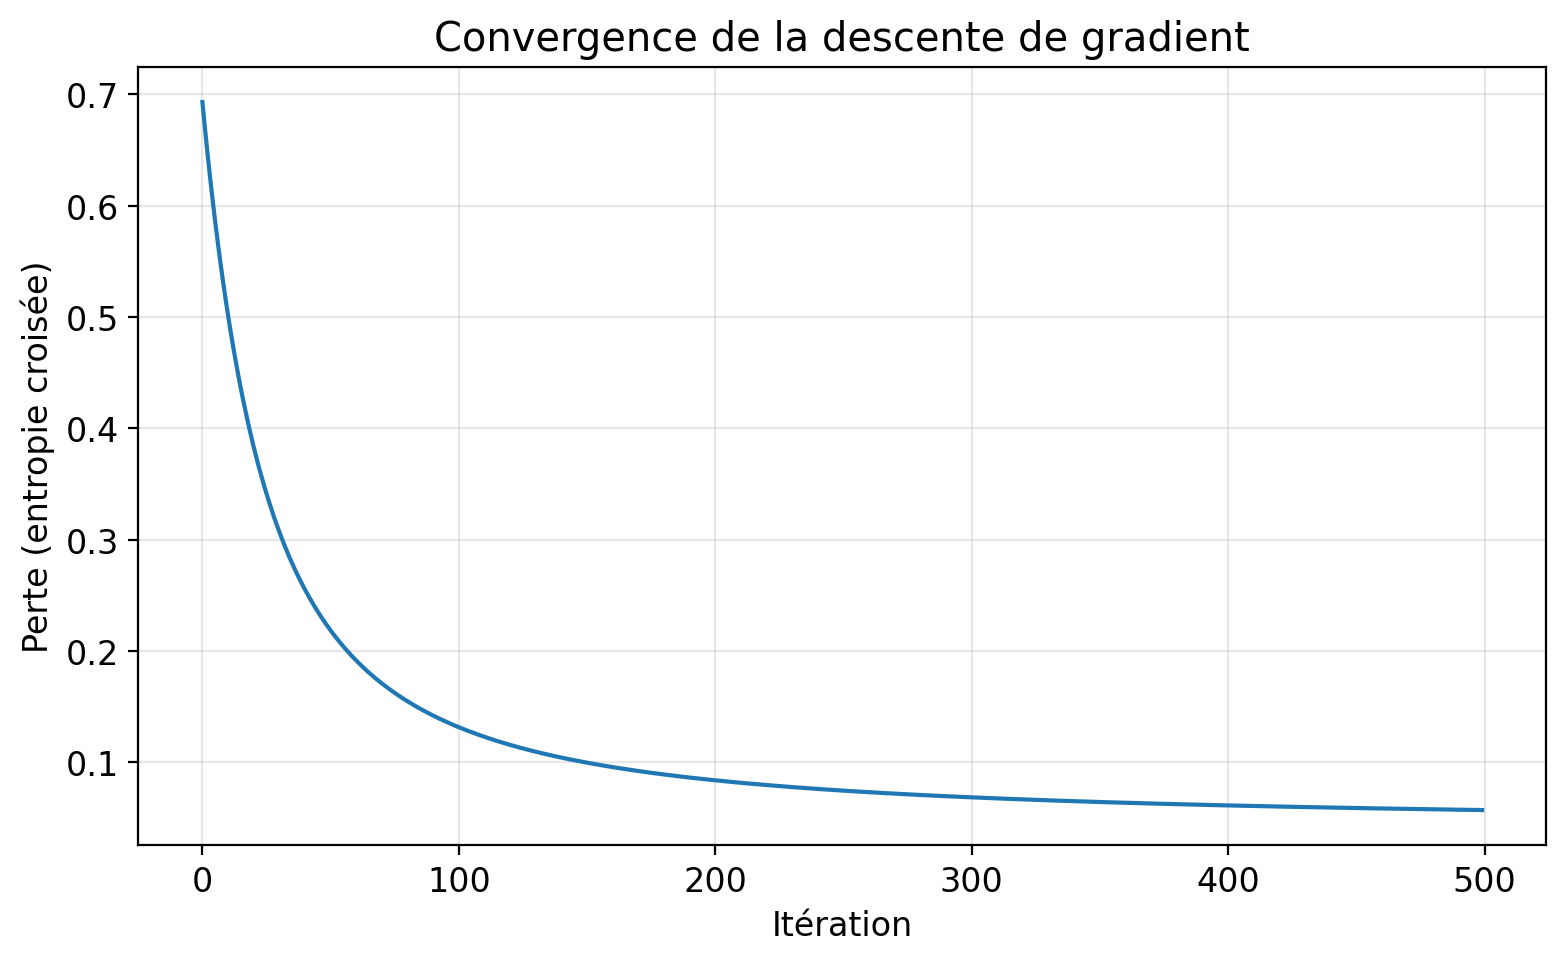

In [12]:
# Test sur la prédiction des événements de pointe
# Caractéristiques pour classification
features_clf = ['temperature_ext', 'heure_sin', 'heure_cos', 'est_weekend']

X_train_clf = train[features_clf].values
y_train_clf = train['evenement_pointe'].values
X_test_clf = test[features_clf].values
y_test_clf = test['evenement_pointe'].values

# Normaliser (recommandé pour la descente de gradient)
scaler = StandardScaler()
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

# Entraîner votre modèle
beta_log, losses = logistic_fit_gd(X_train_clf_scaled, y_train_clf, lr=0.1, n_iter=500, verbose=True)

# Tracer la courbe de convergence
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.xlabel('Itération')
plt.ylabel('Perte (entropie croisée)')
plt.title('Convergence de la descente de gradient')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [13]:
# Évaluation
proba_train = logistic_predict_proba(X_train_clf_scaled, beta_log)
proba_test = logistic_predict_proba(X_test_clf_scaled, beta_log)

y_pred_train = (proba_train >= 0.5).astype(int)
y_pred_test = (proba_test >= 0.5).astype(int)

print("Évaluation de votre régression logistique:")
print(f"  Accuracy (train): {accuracy_score(y_train_clf, y_pred_train):.4f}")
print(f"  Accuracy (test): {accuracy_score(y_test_clf, y_pred_test):.4f}")
print(f"\nRapport de classification (test):")
print(classification_report(y_test_clf, y_pred_test, target_names=['Normal', 'Pointe']))

Évaluation de votre régression logistique:
  Accuracy (train): 0.9905
  Accuracy (test): 0.9840

Rapport de classification (test):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      1726
      Pointe       0.00      0.00      0.00        28

    accuracy                           0.98      1754
   macro avg       0.49      0.50      0.50      1754
weighted avg       0.97      0.98      0.98      1754




ANALYSE APPROFONDIE CLASSIFICATION

Métriques détaillées:
  True Negatives:  1726
  False Positives: 0 (fausses alarmes)
  False Negatives: 28 (pointes manquées)
  True Positives:  0

  Precision: 0.0000 (Quand on prédit pointe, c'est vrai dans 0.0% cas)
  Recall:    0.0000 (On détecte 0.0% des vraies pointes)
  F1-score:  0.0000

  AUC-ROC: 0.9488 (1.0 = parfait, 0.5 = hasard)


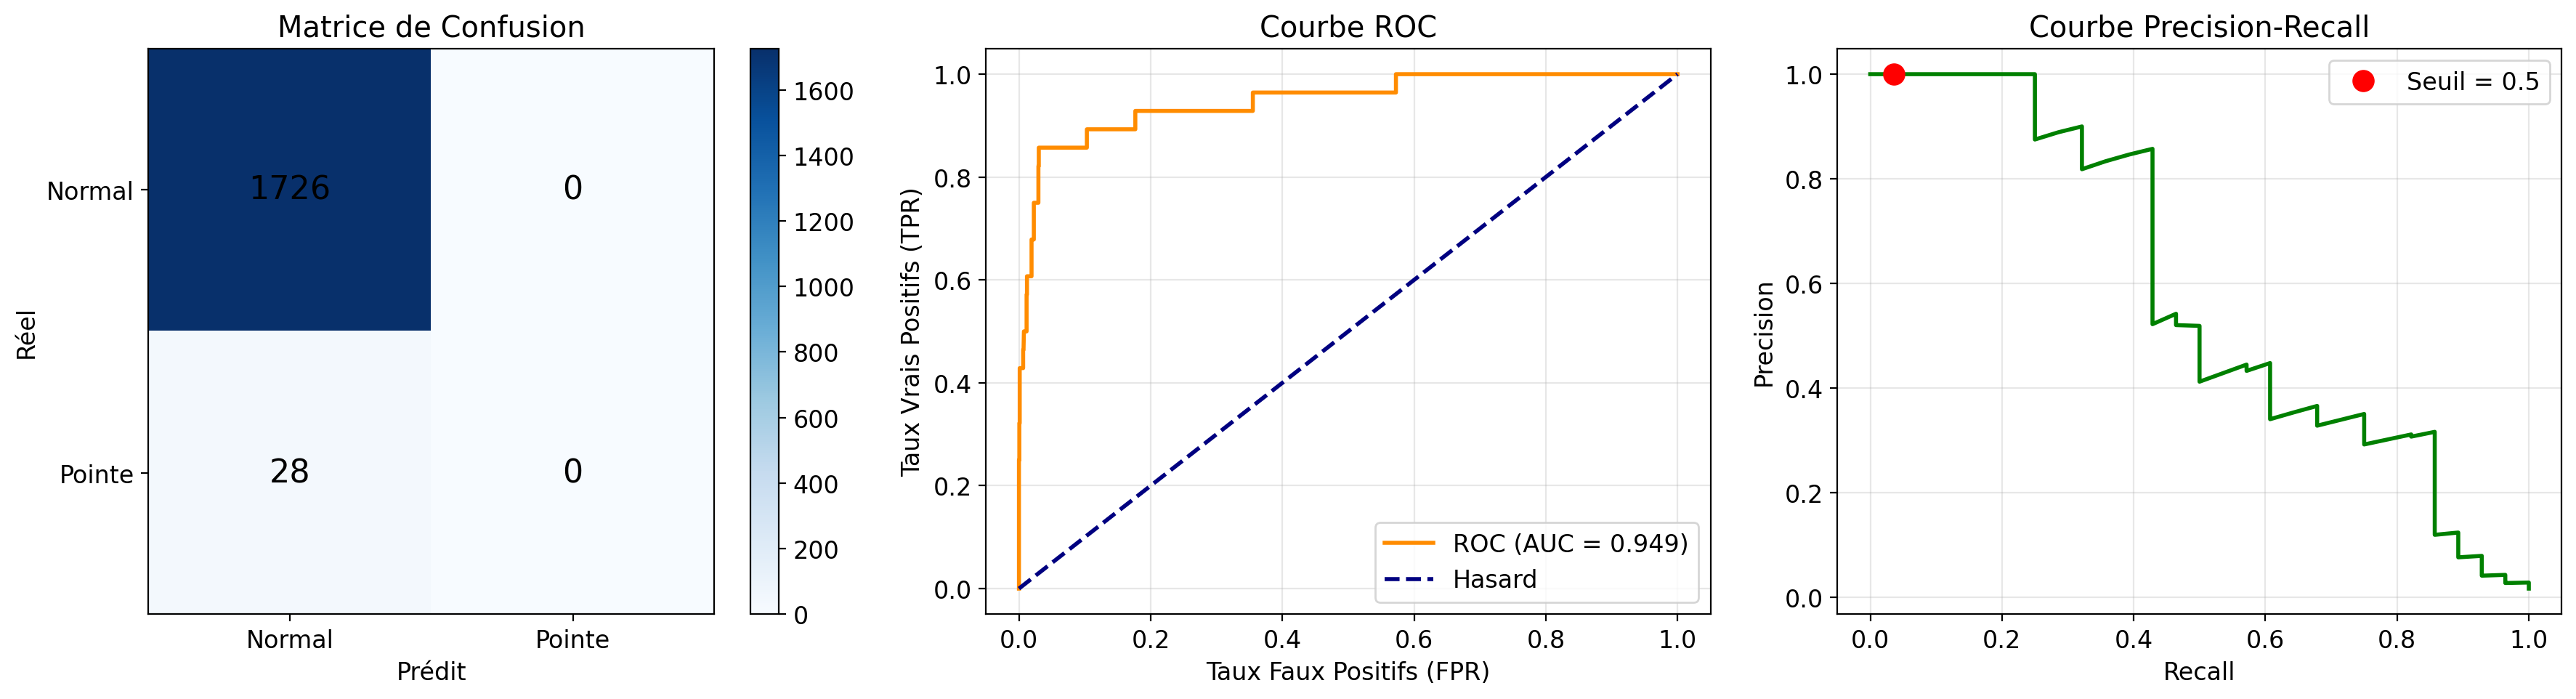


EFFET DU SEUIL DE DÉCISION
 Seuil  Accuracy  Precision  Recall  FP  FN
   0.3  0.984036          0     0.0   0  28
   0.4  0.984036          0     0.0   0  28
   0.5  0.984036          0     0.0   0  28
   0.6  0.984036          0     0.0   0  28
   0.7  0.984036          0     0.0   0  28

Interprétation:
  - Seuil bas (0.3): Plus de détections → Recall élevé, mais plus de fausses alarmes
  - Seuil élevé (0.7): Moins de fausses alarmes → Precision élevée, mais pointes manquées
  - Trade-off selon contexte métier!


In [14]:
print("\n" + "="*60)
print("ANALYSE APPROFONDIE CLASSIFICATION")
print("="*60)

# 1. Matrice de confusion détaillée
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_clf, y_pred_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Matrice de confusion
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Normal', 'Pointe'])
axes[0].set_yticklabels(['Normal', 'Pointe'])
axes[0].set_xlabel('Prédit')
axes[0].set_ylabel('Réel')
axes[0].set_title('Matrice de Confusion')

# Annoter nombres
for i in range(2):
    for j in range(2):
        text = axes[0].text(j, i, cm[i, j],
                           ha="center", va="center", color="black", fontsize=16)

plt.colorbar(im, ax=axes[0])

# Calculer métriques
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nMétriques détaillées:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp} (fausses alarmes)")
print(f"  False Negatives: {fn} (pointes manquées)")
print(f"  True Positives:  {tp}")
print(f"\n  Precision: {precision:.4f} (Quand on prédit pointe, c'est vrai dans {precision*100:.1f}% cas)")
print(f"  Recall:    {recall:.4f} (On détecte {recall*100:.1f}% des vraies pointes)")
print(f"  F1-score:  {f1:.4f}")


# 2. Courbe ROC et AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_clf, proba_test)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2,
            label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
            label='Hasard')
axes[1].set_xlabel('Taux Faux Positifs (FPR)')
axes[1].set_ylabel('Taux Vrais Positifs (TPR)')
axes[1].set_title('Courbe ROC')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

print(f"\n  AUC-ROC: {roc_auc:.4f} (1.0 = parfait, 0.5 = hasard)")


# 3. Precision-Recall selon seuil
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test_clf, proba_test)

axes[2].plot(recall_vals, precision_vals, color='green', lw=2)
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Courbe Precision-Recall')
axes[2].grid(True, alpha=0.3)

# Marquer le seuil 0.5
idx_05 = np.argmin(np.abs(thresholds_pr - 0.5))
axes[2].plot(recall_vals[idx_05], precision_vals[idx_05], 'ro',
            markersize=10, label='Seuil = 0.5')
axes[2].legend()

plt.tight_layout()
plt.show()


# 4. Analyse par seuil
print(f"\n{'='*60}")
print("EFFET DU SEUIL DE DÉCISION")
print("="*60)

seuils_test = [0.3, 0.4, 0.5, 0.6, 0.7]
results_seuils = []

for seuil in seuils_test:
    y_pred_seuil = (proba_test >= seuil).astype(int)
    acc = accuracy_score(y_test_clf, y_pred_seuil)
    cm_seuil = confusion_matrix(y_test_clf, y_pred_seuil)
    tn, fp, fn, tp = cm_seuil.ravel()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    results_seuils.append({
        'Seuil': seuil,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'FP': fp,
        'FN': fn
    })

df_seuils = pd.DataFrame(results_seuils)
print(df_seuils.to_string(index=False))

print("\nInterprétation:")
print("  - Seuil bas (0.3): Plus de détections → Recall élevé, mais plus de fausses alarmes")
print("  - Seuil élevé (0.7): Moins de fausses alarmes → Precision élevée, mais pointes manquées")
print("  - Trade-off selon contexte métier!")

---

## Partie 3: Ingénierie des caractéristiques (15%)

**À partir de maintenant, vous pouvez utiliser scikit-learn.**

Créez des caractéristiques temporelles pour améliorer le modèle de régression.

### Caractéristiques à implémenter:

1. **Retards (lags)**: consommation aux heures précédentes
2. **Statistiques glissantes**: moyenne mobile, écart-type mobile
3. **Interactions**: température × heure, etc.

Implémentez **au moins 3 nouvelles caractéristiques**.

In [15]:
def creer_caracteristiques(df):
    """
    Crée des caractéristiques supplémentaires.
    
    VOUS DEVEZ IMPLÉMENTER AU MOINS 3 NOUVELLES CARACTÉRISTIQUES.
    
    Idées:
    - Retards: df['energie_kwh'].shift(1), shift(24)
    - Moyennes mobiles: df['energie_kwh'].rolling(6).mean()
    - Interactions: df['temperature_ext'] * df['heure_cos']
    - Degré-jours de chauffage: np.maximum(18 - df['temperature_ext'], 0)
    """
    df = df.copy()
    
    # VOTRE CODE ICI
    # Exemple:
    df['energie_lag1'] = df['energie_kwh'].shift(1)
    df['energie_lag24'] = df['energie_kwh'].shift(24)
    df['energie_lag168'] = df['energie_kwh'].shift(168)
    
    df['energie_rolling_6h'] = df['energie_kwh'].rolling(6).mean()
    df['energie_rolling_24h'] = df['energie_kwh'].rolling(24).mean()
    df['energie_rolling_std_24h'] = df['energie_kwh'].rolling(
        window=24, 
        min_periods=1
    ).std().fillna(0)
    df['energie_rolling_max_12h'] = df['energie_kwh'].rolling(
        window = 12,
        min_periods=1
    ).max()
    
    df['temp_heure_cos'] = df['temperature_ext'] * df['heure_cos']
    df['temp_heure_sin'] = df['temperature_ext'] * df['heure_sin']
    df['temp_weekend'] = df['temperature_ext'] * df['est_weekend']
    df['temp_mois_sin'] = df['temperature_ext'] * df['mois_sin']
    df['temp_mois_cos'] = df['temperature_ext'] * df['mois_cos']
    
    df['degres_jours_chauffage'] = np.maximum(18 - df['temperature_ext'], 0)
    df['degres_jours_clim'] = np.maximum(df['temperature_ext'] - 22, 0)
    df['temp_squared'] = df['temperature_ext'] ** 2
    df['temp_ressentie'] = df['temperature_ext'] - 0.5 * df['vitesse_vent']
    df['humidite_temp'] = df['humidite'] * np.abs(df['temperature_ext']) / 100
    df['est_pointe_matin'] = ((df['heure'] >= 7) & (df['heure'] <= 9)).astype(int)
    
    df['est_pointe_soir'] = ((df['heure'] >= 17) & (df['heure'] <= 20)).astype(int)
    df['est_nuit'] = ((df['heure'] >= 0) & (df['heure'] <= 6)).astype(int)
    df['est_hiver'] = df['mois'].isin([12, 1, 2]).astype(int)
    df['est_ete'] = df['mois'].isin([6, 7, 8]).astype(int)
    
    df['temp_rolling_mean_3h'] = df['temperature_ext'].rolling(
        window=3, 
        min_periods=1
    ).mean()
    df['temp_diff'] = df['temperature_ext'].diff().fillna(0)
    df['temp_amplitude_24h'] = (
        df['temperature_ext'].rolling(window=24, min_periods=1).max() - 
        df['temperature_ext'].rolling(window=24, min_periods=1).min()
    )
    
    if 'clients_connectes' in df.columns:
        df['clients_temp'] = df['clients_connectes'] * df['temperature_ext']
        df['energie_per_client'] = df['energie_kwh'] / (df['clients_connectes'] + 1)
        df['clients_weekend'] = df['clients_connectes'] * df['est_weekend']
    
    return df

# Appliquer aux données
train_eng = creer_caracteristiques(train)
test_eng = creer_caracteristiques(test)

# Supprimer les lignes avec NaN (dues aux retards)
train_eng = train_eng.dropna().reset_index(drop=True)
test_eng = test_eng.dropna().reset_index(drop=True)

print(f"Nouvelles colonnes: {[c for c in train_eng.columns if c not in train.columns]}")

Nouvelles colonnes: ['energie_lag1', 'energie_lag24', 'energie_lag168', 'energie_rolling_6h', 'energie_rolling_24h', 'energie_rolling_std_24h', 'energie_rolling_max_12h', 'temp_heure_cos', 'temp_heure_sin', 'temp_weekend', 'temp_mois_sin', 'temp_mois_cos', 'degres_jours_chauffage', 'degres_jours_clim', 'temp_squared', 'temp_ressentie', 'humidite_temp', 'est_pointe_matin', 'est_pointe_soir', 'est_nuit', 'est_hiver', 'est_ete', 'temp_rolling_mean_3h', 'temp_diff', 'temp_amplitude_24h', 'clients_temp', 'energie_per_client', 'clients_weekend']


In [16]:
train_enrichi = creer_caracteristiques(train)
test_enrichi = creer_caracteristiques(test)

# Supprimer les NaN (dus aux lags/rolling)
train_enrichi = train_enrichi.dropna().reset_index(drop=True)
test_enrichi = test_enrichi.dropna().reset_index(drop=True)

# Vérifier les nouvelles colonnes
nouvelles_cols = [c for c in train_enrichi.columns if c not in train.columns]
print(f"Nombre de nouvelles features: {len(nouvelles_cols)}")
print(f"\nNouvelles features créées:")
for col in nouvelles_cols:
    print(f"  - {col}")

# Vérifier corrélations avec la cible
correlations = train_enrichi[nouvelles_cols + ['energie_kwh']].corr()['energie_kwh'].sort_values(ascending=False)
print(f"\nTop 10 features par corrélation avec energie_kwh:")
print(correlations.head(10))

features_to_use = [
    # Météo de base
    'temperature_ext', 'humidite', 'vitesse_vent', 'irradiance_solaire',
    
    # Temps cyclique
    'heure_sin', 'heure_cos', 'mois_sin', 'mois_cos',
    'jour_semaine_sin', 'jour_semaine_cos',
    
    # Indicateurs binaires
    'est_weekend', 'est_ferie', 'est_pointe_matin', 'est_pointe_soir',
    
    # TRÈS IMPORTANT
    'clients_connectes',
    
    # Lags (attention Kaggle!)
    'energie_lag1', 'energie_lag24',
    
    # Rolling
    'energie_rolling_mean_6h', 'energie_rolling_mean_24h',
    
    # Interactions
    'temp_heure_cos', 'temp_weekend',
    
    # Transformations météo
    'degres_jours_chauffage', 'temp_squared'
]

# Filtrer celles qui existent vraiment
features_disponibles = [f for f in features_to_use if f in train_enrichi.columns]

print(f"\nFeatures sélectionnées: {len(features_disponibles)}")

X_train = train_enrichi[features_disponibles].values
y_train = train_enrichi['energie_kwh'].values
X_test = test_enrichi[features_disponibles].values
y_test = test_enrichi['energie_kwh'].values

# Entraîner un modèle simple pour tester
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

from sklearn.metrics import r2_score
print(f"\nR² avec features enrichies: {r2_score(y_test, model.predict(X_test)):.4f}")

Nombre de nouvelles features: 28

Nouvelles features créées:
  - energie_lag1
  - energie_lag24
  - energie_lag168
  - energie_rolling_6h
  - energie_rolling_24h
  - energie_rolling_std_24h
  - energie_rolling_max_12h
  - temp_heure_cos
  - temp_heure_sin
  - temp_weekend
  - temp_mois_sin
  - temp_mois_cos
  - degres_jours_chauffage
  - degres_jours_clim
  - temp_squared
  - temp_ressentie
  - humidite_temp
  - est_pointe_matin
  - est_pointe_soir
  - est_nuit
  - est_hiver
  - est_ete
  - temp_rolling_mean_3h
  - temp_diff
  - temp_amplitude_24h
  - clients_temp
  - energie_per_client
  - clients_weekend

Top 10 features par corrélation avec energie_kwh:
energie_kwh                1.000000
energie_per_client         0.818197
energie_rolling_6h         0.747086
energie_rolling_24h        0.692640
energie_lag1               0.504552
energie_lag24              0.448435
energie_rolling_max_12h    0.432027
degres_jours_chauffage     0.412301
energie_lag168             0.407889
est_hiver  

ANALYSE D'IMPACT DES NOUVELLES FEATURES


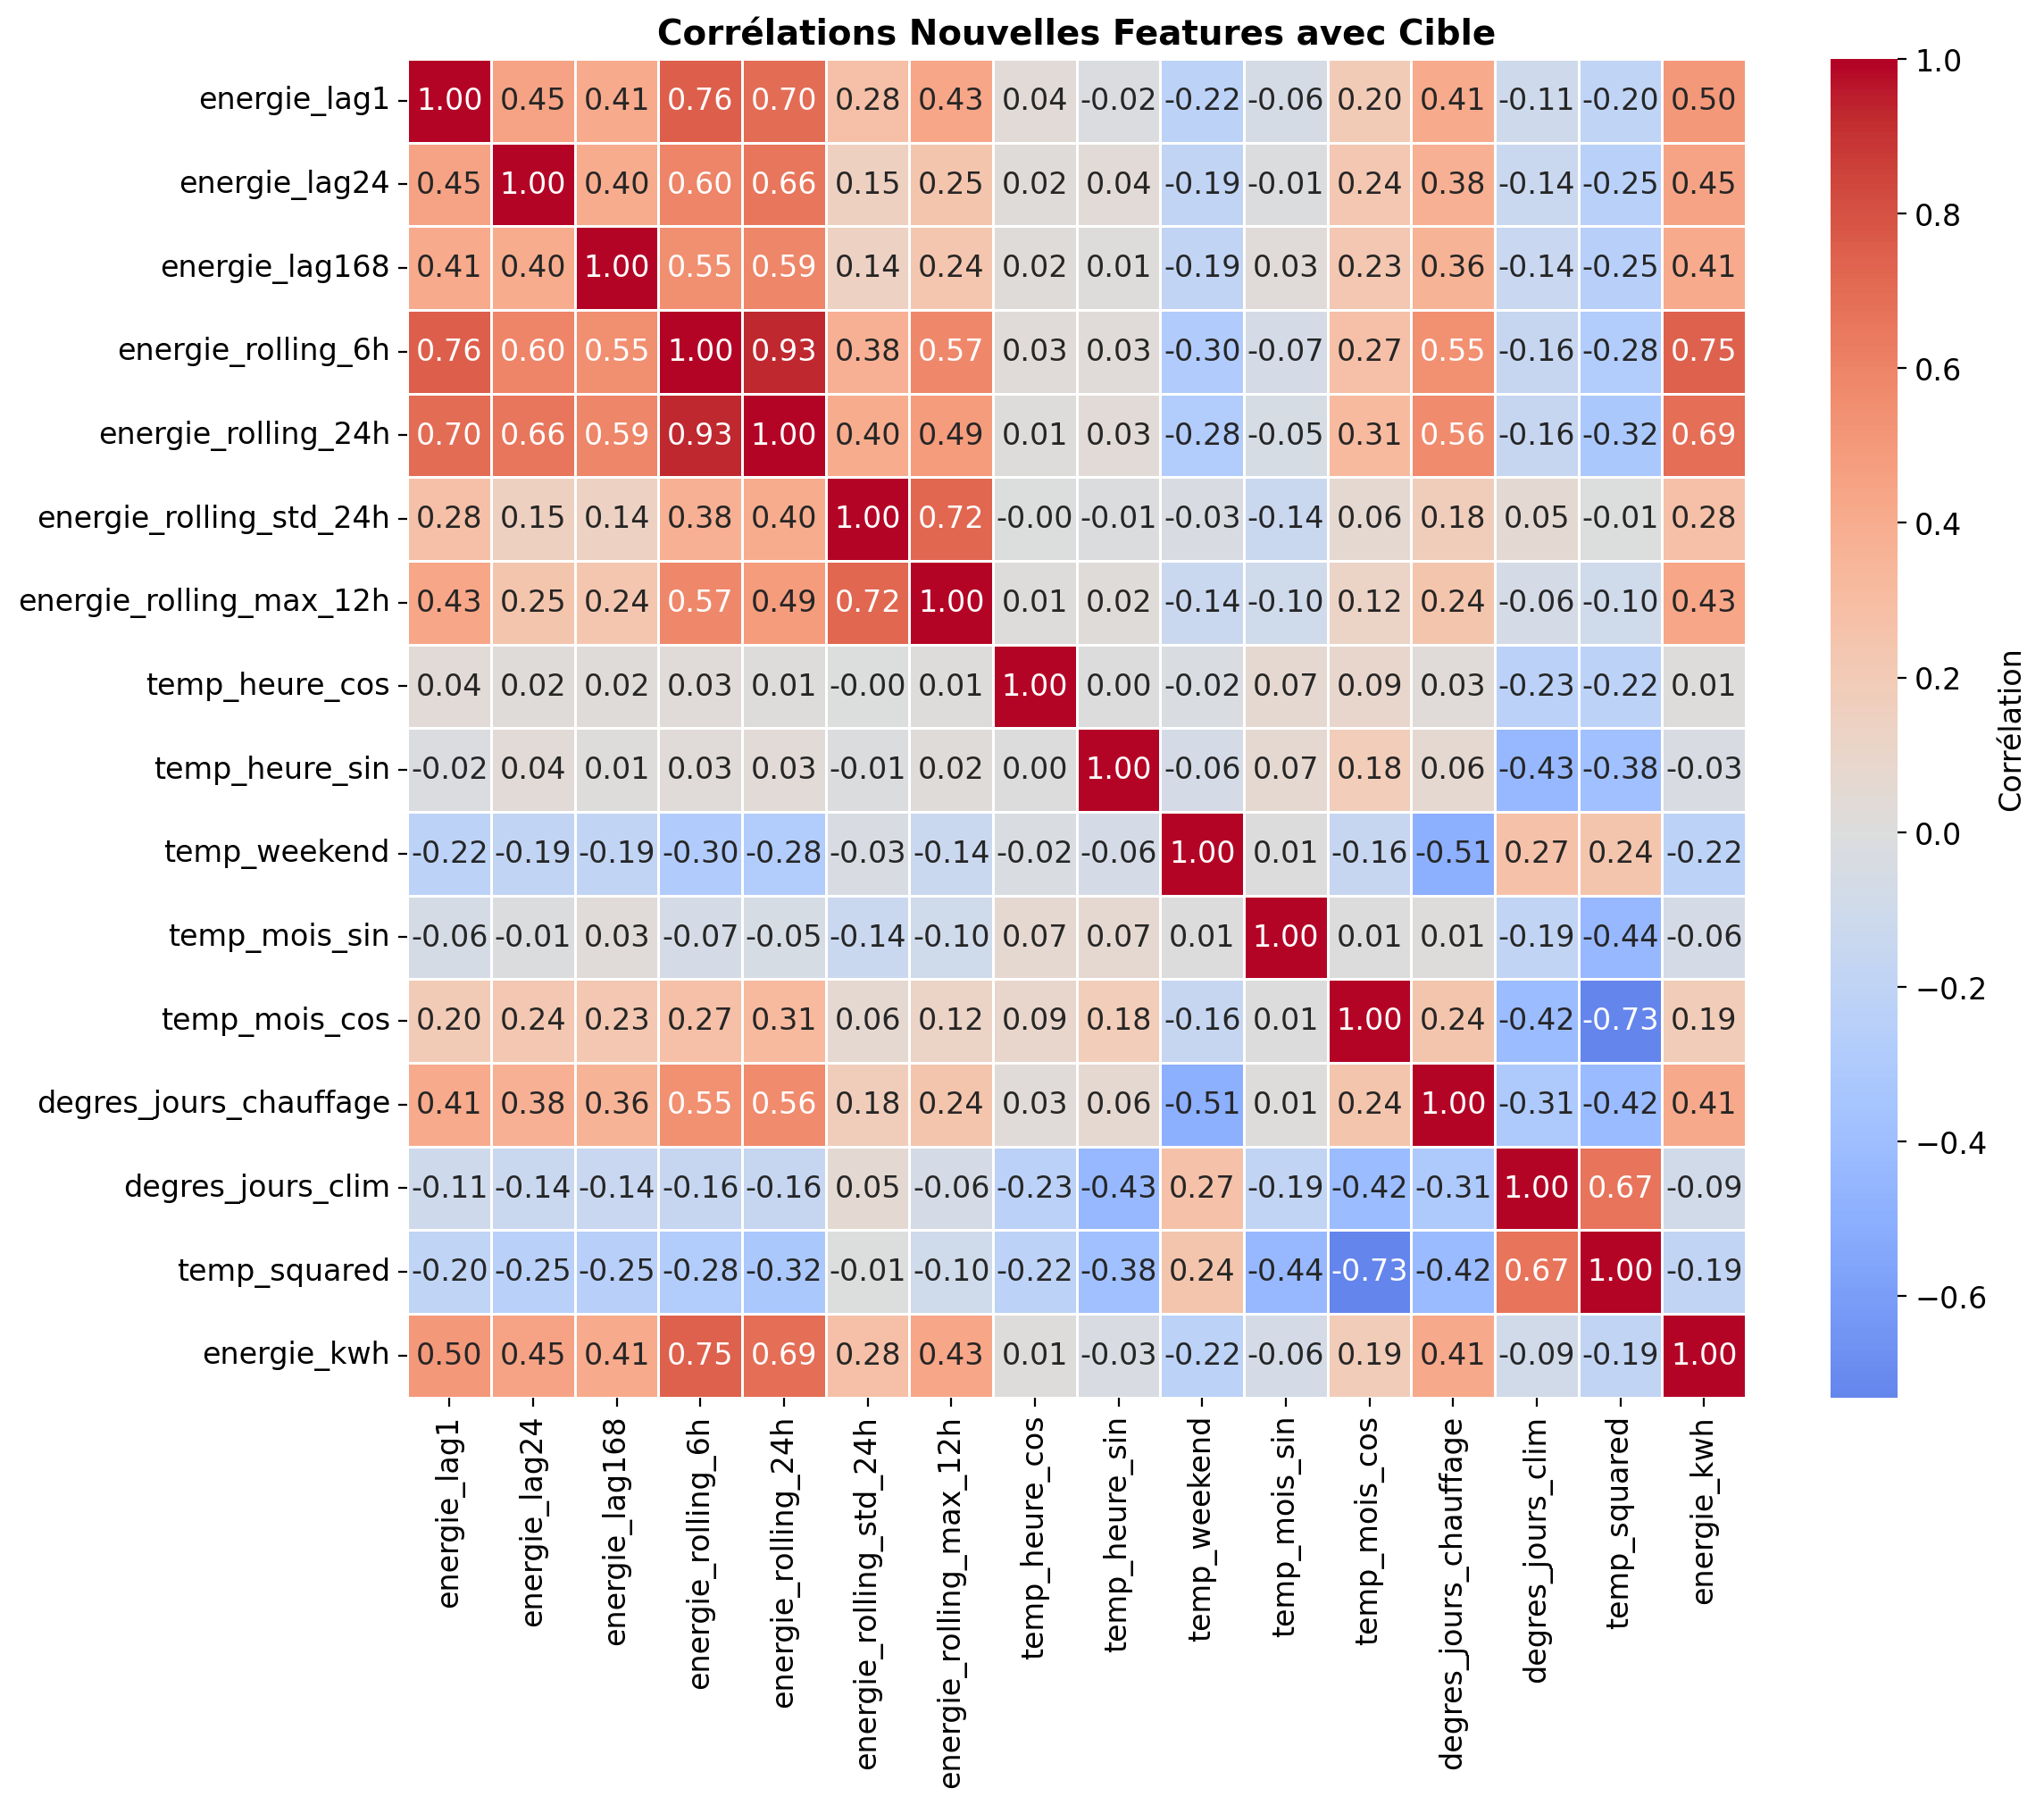


TEST INCRÉMENTAL - IMPACT PAR TYPE DE FEATURE
    Configuration  Nb Features   R² Test  RMSE Test
         Baseline            9 -0.336747  68.924089
           + Lags           11  0.276659  50.701177
        + Rolling           13  0.658706  34.826587
   + Interactions           15  0.662455  34.634792
+ Transformations           17  0.664650  34.521973


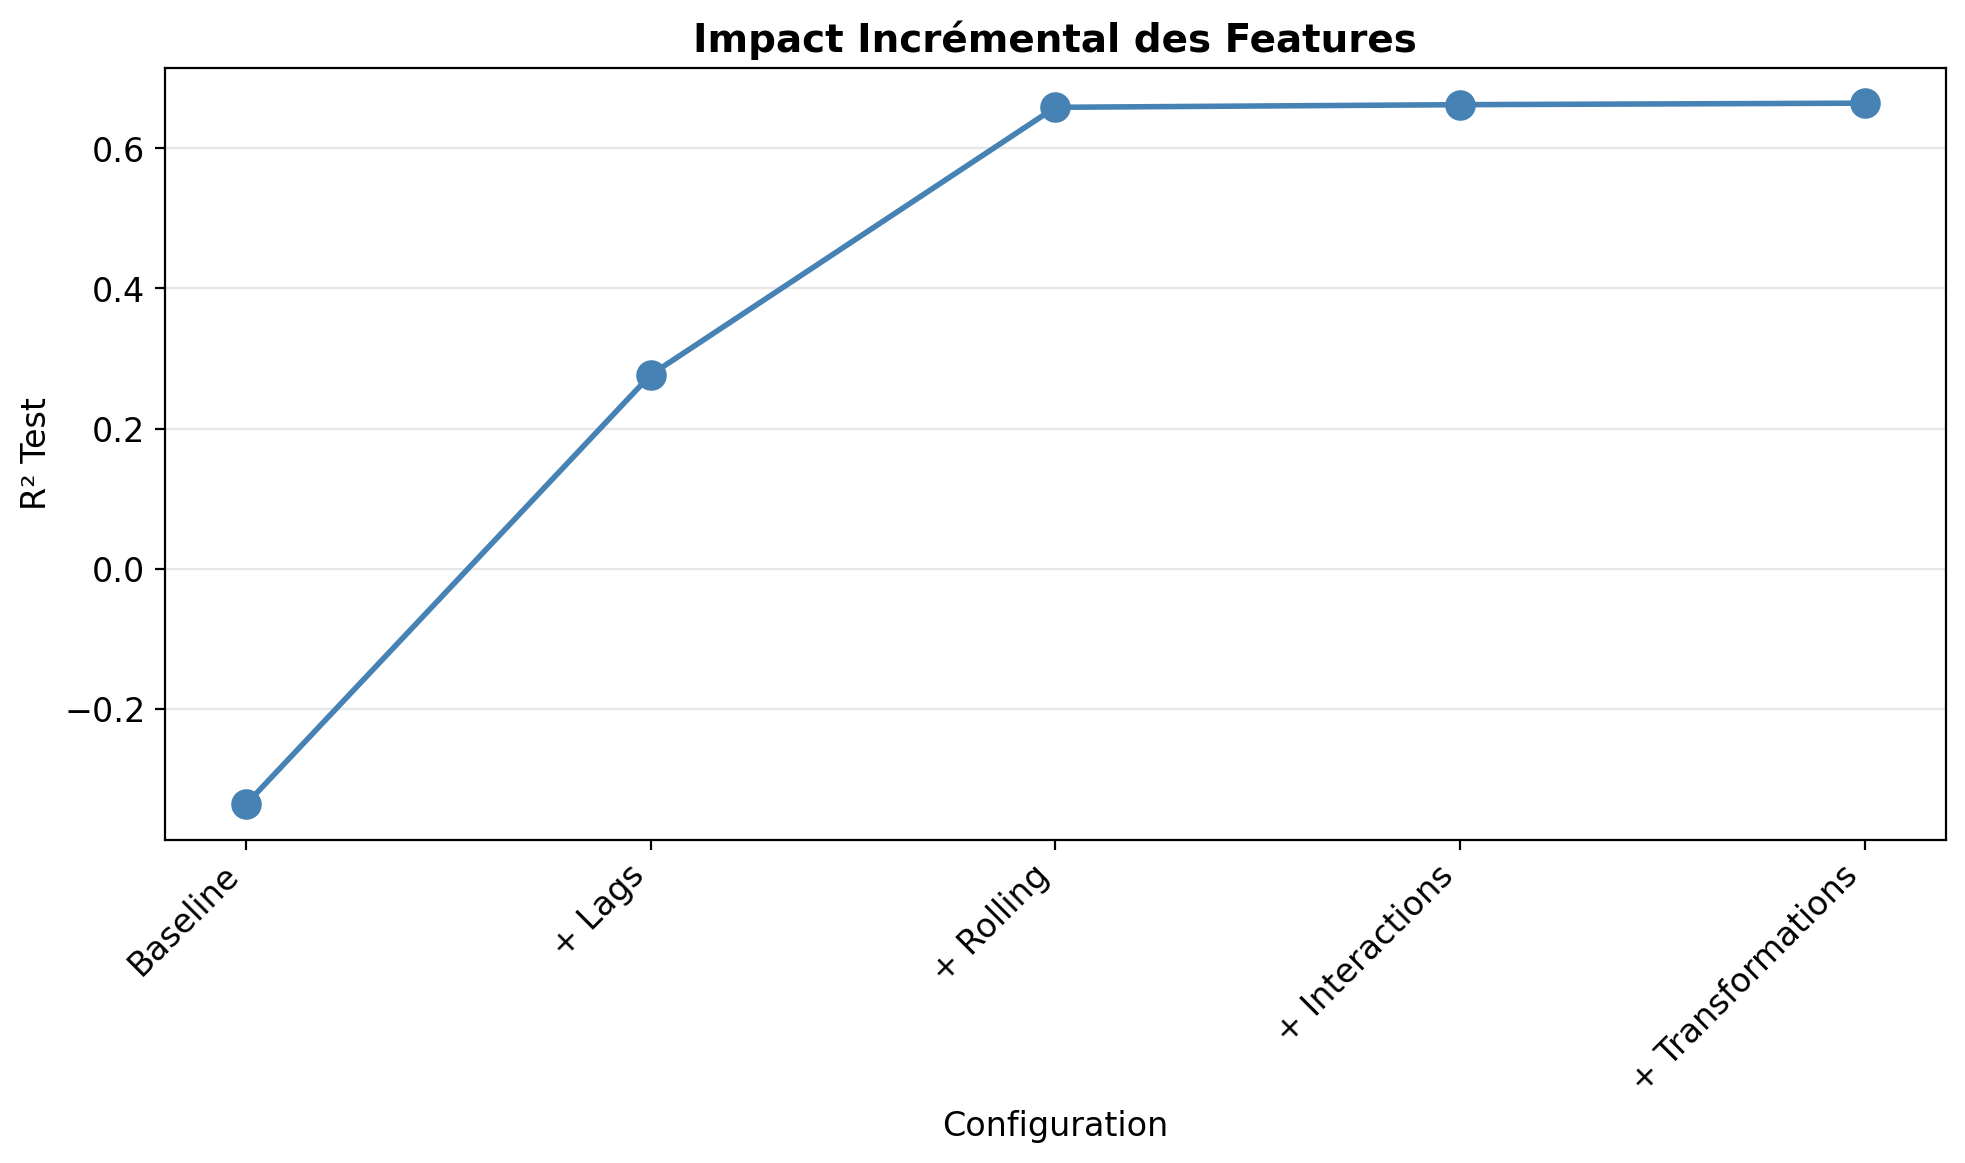


Amélioration totale: +1.0014 R²


In [18]:
print("="*60)
print("ANALYSE D'IMPACT DES NOUVELLES FEATURES")
print("="*60)

# 1. Heatmap corrélations nouvelles features
nouvelles_features_sample = nouvelles_cols[:15]  # Top 15
corr_nouvelles = train_enrichi[nouvelles_features_sample + ['energie_kwh']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_nouvelles, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={'label': 'Corrélation'})
plt.title('Corrélations Nouvelles Features avec Cible', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Test incrémental d'ajout de features
print(f"\n{'='*60}")
print("TEST INCRÉMENTAL - IMPACT PAR TYPE DE FEATURE")
print("="*60)

from sklearn.linear_model import Ridge

# Baseline: features de base
features_baseline = ['temperature_ext', 'humidite', 'vitesse_vent',
                     'heure_sin', 'heure_cos', 'mois_sin', 'mois_cos',
                     'est_weekend', 'clients_connectes']

# Test progressif
feature_groups = {
    'Baseline': features_baseline,
    '+ Lags': features_baseline + ['energie_lag1', 'energie_lag24'],
    '+ Rolling': features_baseline + ['energie_lag1', 'energie_lag24',
                                      'energie_rolling_6h', 'energie_rolling_24h'],
    '+ Interactions': features_baseline + ['energie_lag1', 'energie_lag24',
                                           'energie_rolling_6h', 'energie_rolling_24h',
                                           'temp_heure_cos', 'temp_weekend'],
    '+ Transformations': features_baseline + ['energie_lag1', 'energie_lag24',
                                               'energie_rolling_6h', 'energie_rolling_24h',
                                               'temp_heure_cos', 'temp_weekend',
                                               'degres_jours_chauffage', 'temp_squared']
}

results_incremental = []

for name, feats in feature_groups.items():
    feats_avail = [f for f in feats if f in train_enrichi.columns]
    
    X_tr = train_enrichi[feats_avail].values
    y_tr = train_enrichi['energie_kwh'].values
    X_te = test_enrichi[feats_avail].values
    y_te = test_enrichi['energie_kwh'].values
    
    model_temp = Ridge(alpha=1.0)
    model_temp.fit(X_tr, y_tr)
    
    r2_test = r2_score(y_te, model_temp.predict(X_te))
    rmse_test = np.sqrt(mean_squared_error(y_te, model_temp.predict(X_te)))
    
    results_incremental.append({
        'Configuration': name,
        'Nb Features': len(feats_avail),
        'R² Test': r2_test,
        'RMSE Test': rmse_test
    })

df_incremental = pd.DataFrame(results_incremental)
print(df_incremental.to_string(index=False))

# Visualiser amélioration
plt.figure(figsize=(10, 6))
plt.plot(df_incremental['Configuration'], df_incremental['R² Test'],
         'o-', linewidth=2, markersize=10, color='steelblue')
plt.xlabel('Configuration')
plt.ylabel('R² Test')
plt.title('Impact Incrémental des Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nAmélioration totale: +{(df_incremental.iloc[-1]['R² Test'] - df_incremental.iloc[0]['R² Test']):.4f} R²")

---

## Partie 4: Régression Ridge (15%)

Avec plusieurs caractéristiques corrélées, la régularisation devient utile.

1. Entraînez un modèle Ridge avec validation croisée pour choisir λ
2. Comparez les performances avec OLS
3. Analysez comment les coefficients changent

In [19]:
# Définissez vos caractéristiques pour la régression
# MODIFIEZ CETTE LISTE selon vos caractéristiques créées en Partie 3
# IMPORTANT: clients_connectes est une variable très importante!
features_reg = [
    'temperature_ext', 'humidite', 'vitesse_vent', 'irradiance_solaire',
    'heure_sin', 'heure_cos', 'mois_sin', 'mois_cos',
    'jour_semaine_sin', 'jour_semaine_cos',
    'est_weekend', 'est_ferie',
    'clients_connectes',  # Ne pas oublier!
    # Ajoutez vos caractéristiques ici
]

features_reg += features_to_use

# Vérifier que toutes les colonnes existent
features_disponibles = [f for f in features_reg if f in train_eng.columns]
print(f"Caractéristiques utilisées: {len(features_disponibles)}")

X_train_reg = train_eng[features_disponibles].values
y_train_reg = train_eng['energie_kwh'].values
X_test_reg = test_eng[features_disponibles].values
y_test_reg = test_eng['energie_kwh'].values

Caractéristiques utilisées: 34


In [20]:
# Modèle OLS (baseline)
model_ols = LinearRegression()
model_ols.fit(X_train_reg, y_train_reg)

y_pred_ols_test = model_ols.predict(X_test_reg)
y_pred_ols_train = model_ols.predict(X_train_reg)

r2_ols_train = r2_score(y_train_reg, y_pred_ols_train)
r2_ols_test = r2_score(y_test_reg, y_pred_ols_test)
rmse_ols_test = np.sqrt(mean_squared_error(y_test_reg, y_pred_ols_test))

print("OLS (baseline):")
print(f"  R² train: {r2_ols_train:.4f}")
print(f"  R² test:  {r2_ols_test:.4f}")
print(f"  RMSE test: {rmse_ols_test:.4f}")

if r2_ols_train - r2_ols_test > 0.1:
    print(" Attention: surapprentissage détecté avec OLS!")


OLS (baseline):
  R² train: 0.4725
  R² test:  0.3320
  RMSE test: 48.7216
 Attention: surapprentissage détecté avec OLS!


In [21]:
# Modèle Ridge avec validation croisée
# ATTENTION: Utilisez TimeSeriesSplit pour les données temporelles!
from sklearn.model_selection import TimeSeriesSplit

alphas = [0.01, 0.1, 1, 10, 100, 1000]
tscv = TimeSeriesSplit(n_splits=5)

model_ridge = RidgeCV(alphas=alphas, cv=tscv)
model_ridge.fit(X_train_reg, y_train_reg)

y_pred_ridge_train = model_ridge.predict(X_train_reg)
y_pred_ridge_test = model_ridge.predict(X_test_reg)

r2_ridge_train = r2_score(y_train_reg, y_pred_ridge_train)
r2_ridge_test = r2_score(y_test_reg, y_pred_ridge_test)
rmse_ridge_test = np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge_test))

print(f"\nRidge (λ={model_ridge.alpha_}):")
print(f"  R² train: {r2_ridge_train:.4f}")
print(f"  R² test:  {r2_ridge_test:.4f}")
print(f"  RMSE test: {rmse_ridge_test:.4f}")
print(f"  Écart R² train-test: {r2_ridge_train - r2_ridge_test:.4f}")


Ridge (λ=1000.0):
  R² train: 0.4708
  R² test:  0.4113
  RMSE test: 45.7384
  Écart R² train-test: 0.0595


In [22]:
# Comparaison des coefficients OLS vs Ridge
coef_comparison = pd.DataFrame({
    'Caractéristique': features_disponibles,
    'OLS': model_ols.coef_,
    'Ridge': model_ridge.coef_
})
coef_comparison['Réduction (%)'] = 100 * (1 - np.abs(coef_comparison['Ridge']) / (np.abs(coef_comparison['OLS']) + 1e-8))
coef_comparison = coef_comparison.sort_values('Réduction (%)', ascending=False)

print("\nComparaison des coefficients (triés par réduction):")
print(coef_comparison.to_string(index=False))


Comparaison des coefficients (triés par réduction):
       Caractéristique        OLS      Ridge  Réduction (%)
             est_ferie  -2.125423  -0.701598      66.990179
             est_ferie  -2.125423  -0.701598      66.990179
      jour_semaine_cos  -1.922794  -0.705949      63.285252
      jour_semaine_cos  -1.922794  -0.705949      63.285252
              mois_cos   0.241249  -0.101631      57.873201
              mois_cos   0.241249  -0.101631      57.873201
      est_pointe_matin  29.609536  12.810712      56.734507
           est_weekend   5.708706   2.703159      52.648477
           est_weekend   5.708706   2.703159      52.648477
       est_pointe_soir  27.387970  15.193483      44.524975
          vitesse_vent  -0.799922  -0.448768      43.898492
          vitesse_vent  -0.799922  -0.448768      43.898492
      jour_semaine_sin  -1.362020  -0.787201      42.203414
      jour_semaine_sin  -1.362020  -0.787201      42.203414
              mois_sin  10.413722   8.159005   

In [23]:
results = pd.DataFrame({
    'Modèle': ['OLS', 'Ridge (λ=1)', f'Ridge (λ={model_ridge.alpha_})'],
    'R² train': [r2_ols_train, r2_ridge_train, r2_ridge_train],
    'R² test': [r2_ols_test, r2_ridge_test, r2_ridge_test],
    'RMSE test': [rmse_ols_test, rmse_ridge_test, rmse_ridge_test],
    'Écart': [abs(r2_ols_train - r2_ols_test),
              abs(r2_ridge_train - r2_ridge_test),
              abs(r2_ridge_train - r2_ridge_test)]
})

print(results.to_string(index=False))

# Meilleur modèle
best_idx = results['R² test'].idxmax()
print(f"\n Meilleur modèle: {results.loc[best_idx, 'Modèle']}")

          Modèle  R² train  R² test  RMSE test    Écart
             OLS  0.472472 0.332041  48.721587 0.140432
     Ridge (λ=1)  0.470798 0.411335  45.738370 0.059464
Ridge (λ=1000.0)  0.470798 0.411335  45.738370 0.059464

 Meilleur modèle: Ridge (λ=1)


In [24]:
#Analyse des coefficients du meilleur modèle
coef_comparison = pd.DataFrame({
    'Feature': features_disponibles,
    'OLS': model_ols.coef_,
    'Ridge': model_ridge.coef_
})

# Calculer réduction (shrinkage)
coef_comparison['Réduction (%)'] = 100 * (
    1 - np.abs(coef_comparison['Ridge']) / (np.abs(coef_comparison['OLS']) + 1e-8)
)

# Trier par réduction
coef_comparison = coef_comparison.sort_values('Réduction (%)', ascending=False)

print(coef_comparison.to_string(index=False))

print("\n Observations:")
print(f"  - Réduction moyenne: {coef_comparison['Réduction (%)'].mean():.1f}%")
print(f"  - Réduction max: {coef_comparison['Réduction (%)'].max():.1f}%")
print(f"  - Feature la plus réduite: {coef_comparison.iloc[0]['Feature']}")

               Feature        OLS      Ridge  Réduction (%)
             est_ferie  -2.125423  -0.701598      66.990179
             est_ferie  -2.125423  -0.701598      66.990179
      jour_semaine_cos  -1.922794  -0.705949      63.285252
      jour_semaine_cos  -1.922794  -0.705949      63.285252
              mois_cos   0.241249  -0.101631      57.873201
              mois_cos   0.241249  -0.101631      57.873201
      est_pointe_matin  29.609536  12.810712      56.734507
           est_weekend   5.708706   2.703159      52.648477
           est_weekend   5.708706   2.703159      52.648477
       est_pointe_soir  27.387970  15.193483      44.524975
          vitesse_vent  -0.799922  -0.448768      43.898492
          vitesse_vent  -0.799922  -0.448768      43.898492
      jour_semaine_sin  -1.362020  -0.787201      42.203414
      jour_semaine_sin  -1.362020  -0.787201      42.203414
              mois_sin  10.413722   8.159005      21.651404
              mois_sin  10.413722   8.15

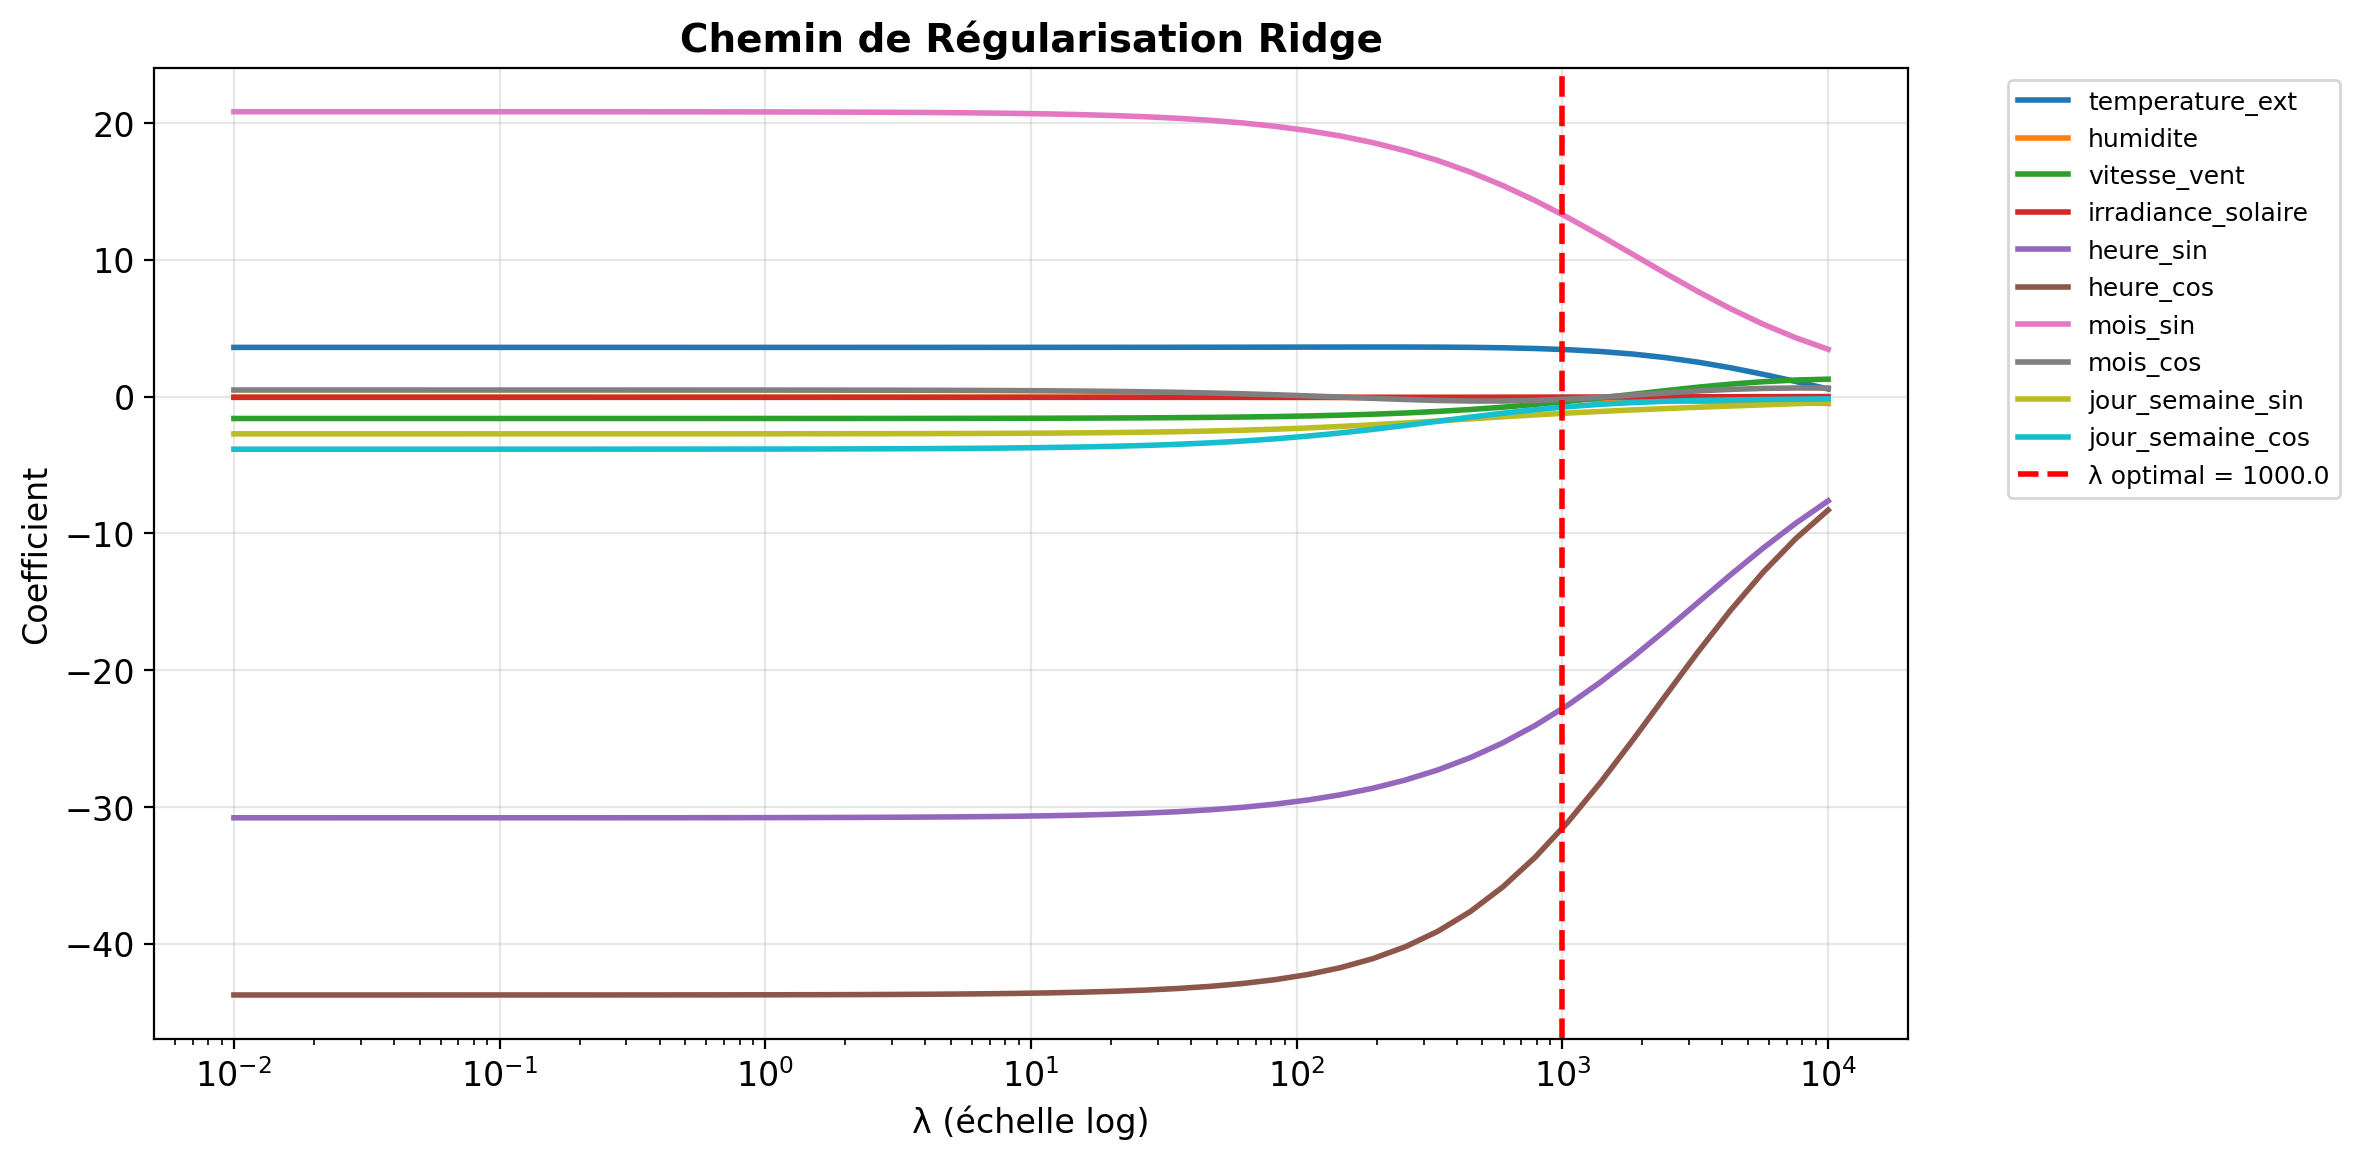

In [25]:
# Tester plusieurs λ
lambdas_test = np.logspace(-2, 4, 50)  # 0.01 à 10000
coefficients_path = []

for lam in lambdas_test:
    model_temp = Ridge(alpha=lam)
    model_temp.fit(X_train, y_train)
    coefficients_path.append(model_temp.coef_)

coefficients_path = np.array(coefficients_path)

# Tracer
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features_disponibles[:10]):  # 10 premières features
    plt.plot(lambdas_test, coefficients_path[:, i], label=feature, linewidth=2)

plt.xscale('log')
plt.xlabel('λ (échelle log)', fontsize=12)
plt.ylabel('Coefficient', fontsize=12)
plt.title('Chemin de Régularisation Ridge', fontsize=14, fontweight='bold')
plt.axvline(model_ridge.alpha_, color='red', linestyle='--',
            linewidth=2, label=f'λ optimal = {model_ridge.alpha_}')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

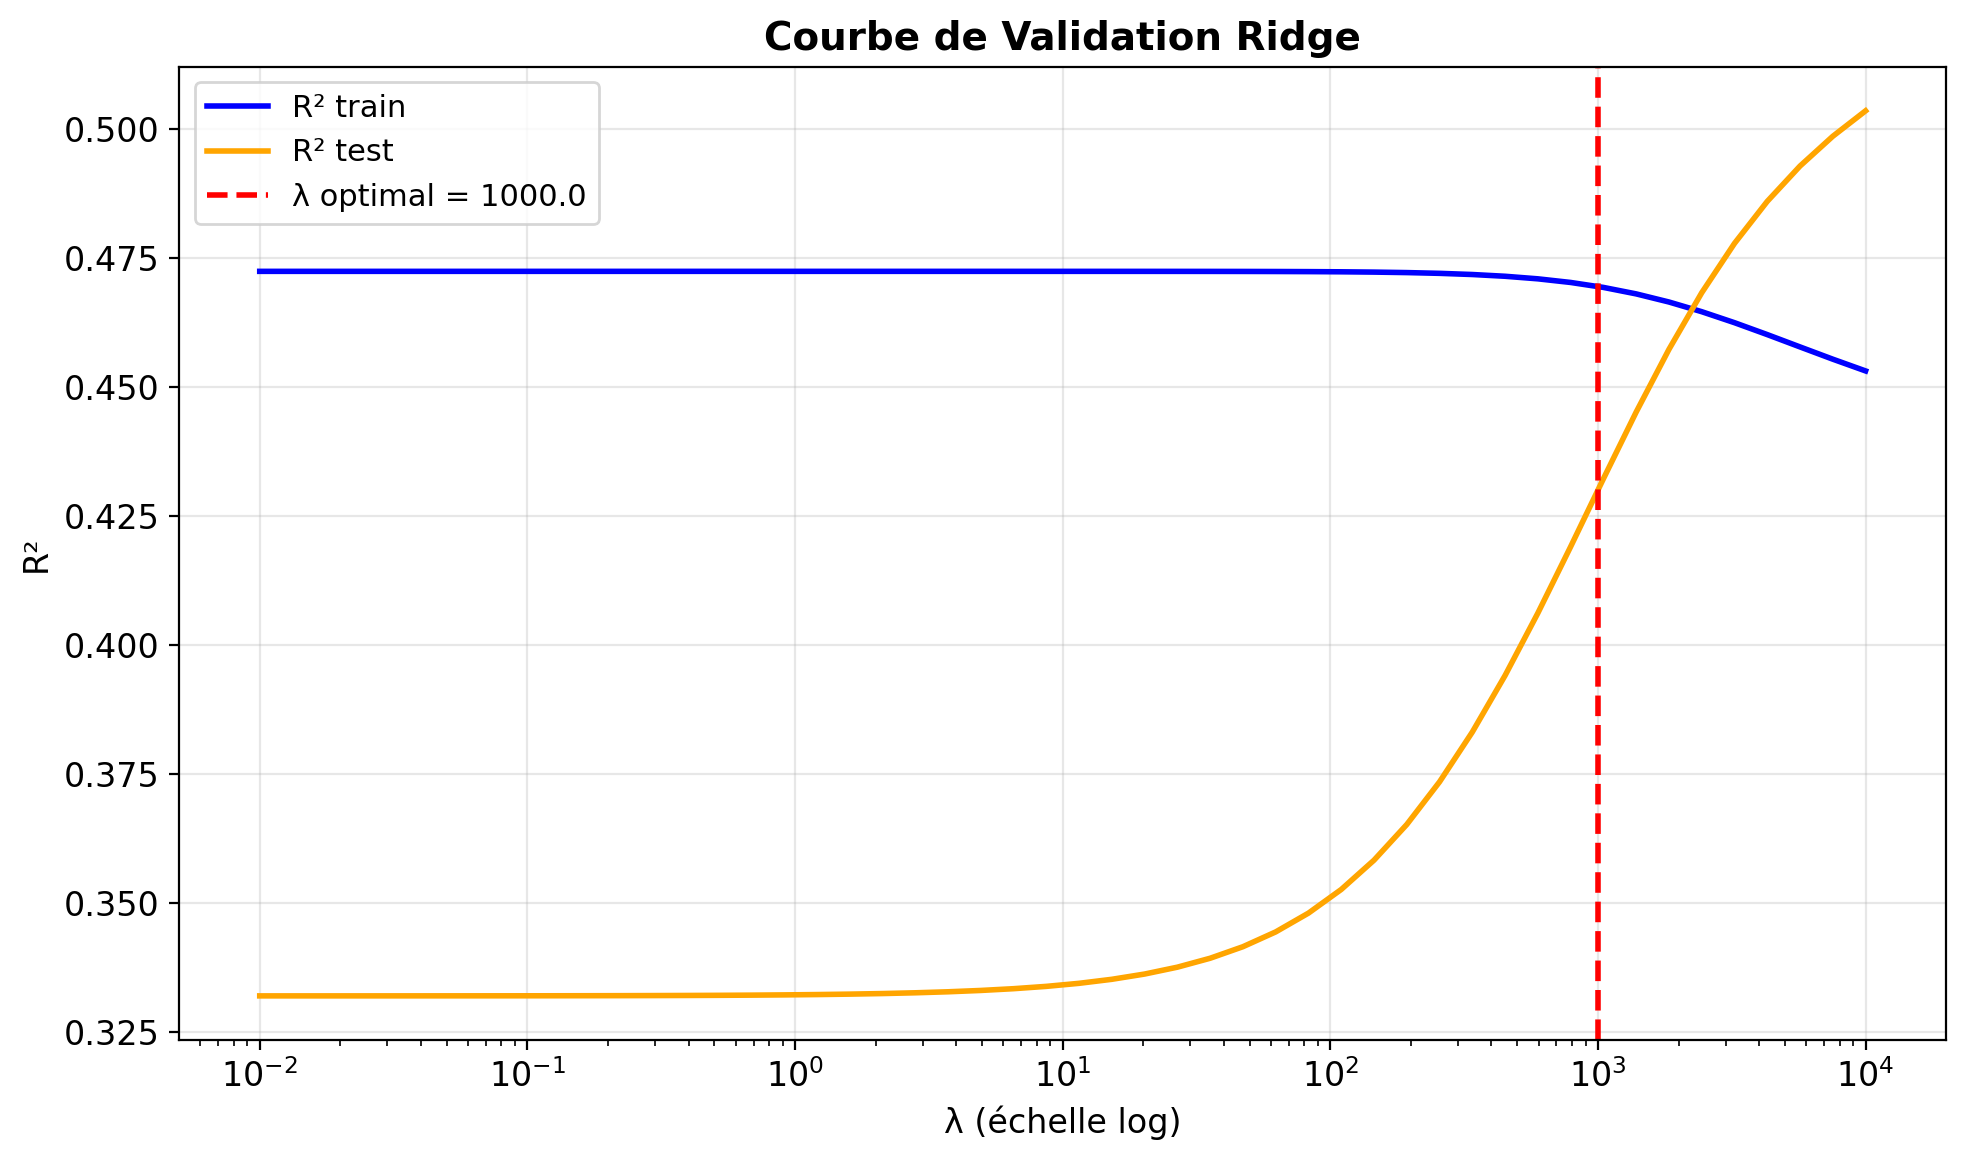

In [26]:
r2_train_list = []
r2_test_list = []

for lam in lambdas_test:
    model_temp = Ridge(alpha=lam)
    model_temp.fit(X_train, y_train)

    r2_train_list.append(r2_score(y_train, model_temp.predict(X_train)))
    r2_test_list.append(r2_score(y_test, model_temp.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(lambdas_test, r2_train_list, label='R² train', linewidth=2, color='blue')
plt.plot(lambdas_test, r2_test_list, label='R² test', linewidth=2, color='orange')
plt.axvline(model_ridge.alpha_, color='red', linestyle='--',
            linewidth=2, label=f'λ optimal = {model_ridge.alpha_}')

plt.xscale('log')
plt.xlabel('λ (échelle log)', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.title('Courbe de Validation Ridge', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

**Questions pour l'entrevue orale**:
- Pourquoi Ridge aide-t-il quand les caractéristiques sont corrélées?
- Quelle caractéristique a été la plus réduite? Pourquoi?
- Comment interpréter Ridge comme estimation MAP?

---

## Partie 5: Sous-tâche de classification (15%)

Entraînez un classifieur pour prédire les événements de pointe, puis utilisez la probabilité prédite comme caractéristique pour la régression.

**Étapes**:
1. Entraîner LogisticRegression sur `evenement_pointe`
2. Extraire `P(pointe)` pour chaque observation
3. Ajouter cette probabilité comme caractéristique pour Ridge

In [27]:
# Caractéristiques pour la classification
# Utilisez des caractéristiques qui ne "trichent" pas (pas de consommation passée pour prédire la pointe)
features_pointe = ['temperature_ext', 'humidite', 'vitesse_vent', 'heure_sin', 'heure_cos', 'est_weekend', 'clients_connectes']

X_train_pointe = train_eng[features_pointe].values
y_train_pointe = train_eng['evenement_pointe'].values
X_test_pointe = test_eng[features_pointe].values
y_test_pointe = test_eng['evenement_pointe'].values

# Entraîner le classifieur
clf_pointe = LogisticRegression(max_iter=1000)
clf_pointe.fit(X_train_pointe, y_train_pointe)

# Évaluation
print("Classification des événements de pointe:")
print(f"  Accuracy (train): {clf_pointe.score(X_train_pointe, y_train_pointe):.4f}")
print(f"  Accuracy (test): {clf_pointe.score(X_test_pointe, y_test_pointe):.4f}")

Classification des événements de pointe:
  Accuracy (train): 0.9900
  Accuracy (test): 0.9868


In [28]:
# Extraire les probabilités
train_eng['P_pointe'] = clf_pointe.predict_proba(X_train_pointe)[:, 1]
test_eng['P_pointe'] = clf_pointe.predict_proba(X_test_pointe)[:, 1]

print(f"Distribution de P(pointe):")
print(f"  Train: moyenne={train_eng['P_pointe'].mean():.3f}, std={train_eng['P_pointe'].std():.3f}")
print(f"  Test:  moyenne={test_eng['P_pointe'].mean():.3f}, std={test_eng['P_pointe'].std():.3f}")

Distribution de P(pointe):
  Train: moyenne=0.010, std=0.035
  Test:  moyenne=0.002, std=0.010


**Question pour l'entrevue**: Pourquoi utiliser P(pointe) au lieu d'un indicateur 0/1?

ANALYSE CALIBRATION ET DISTRIBUTION P(pointe)


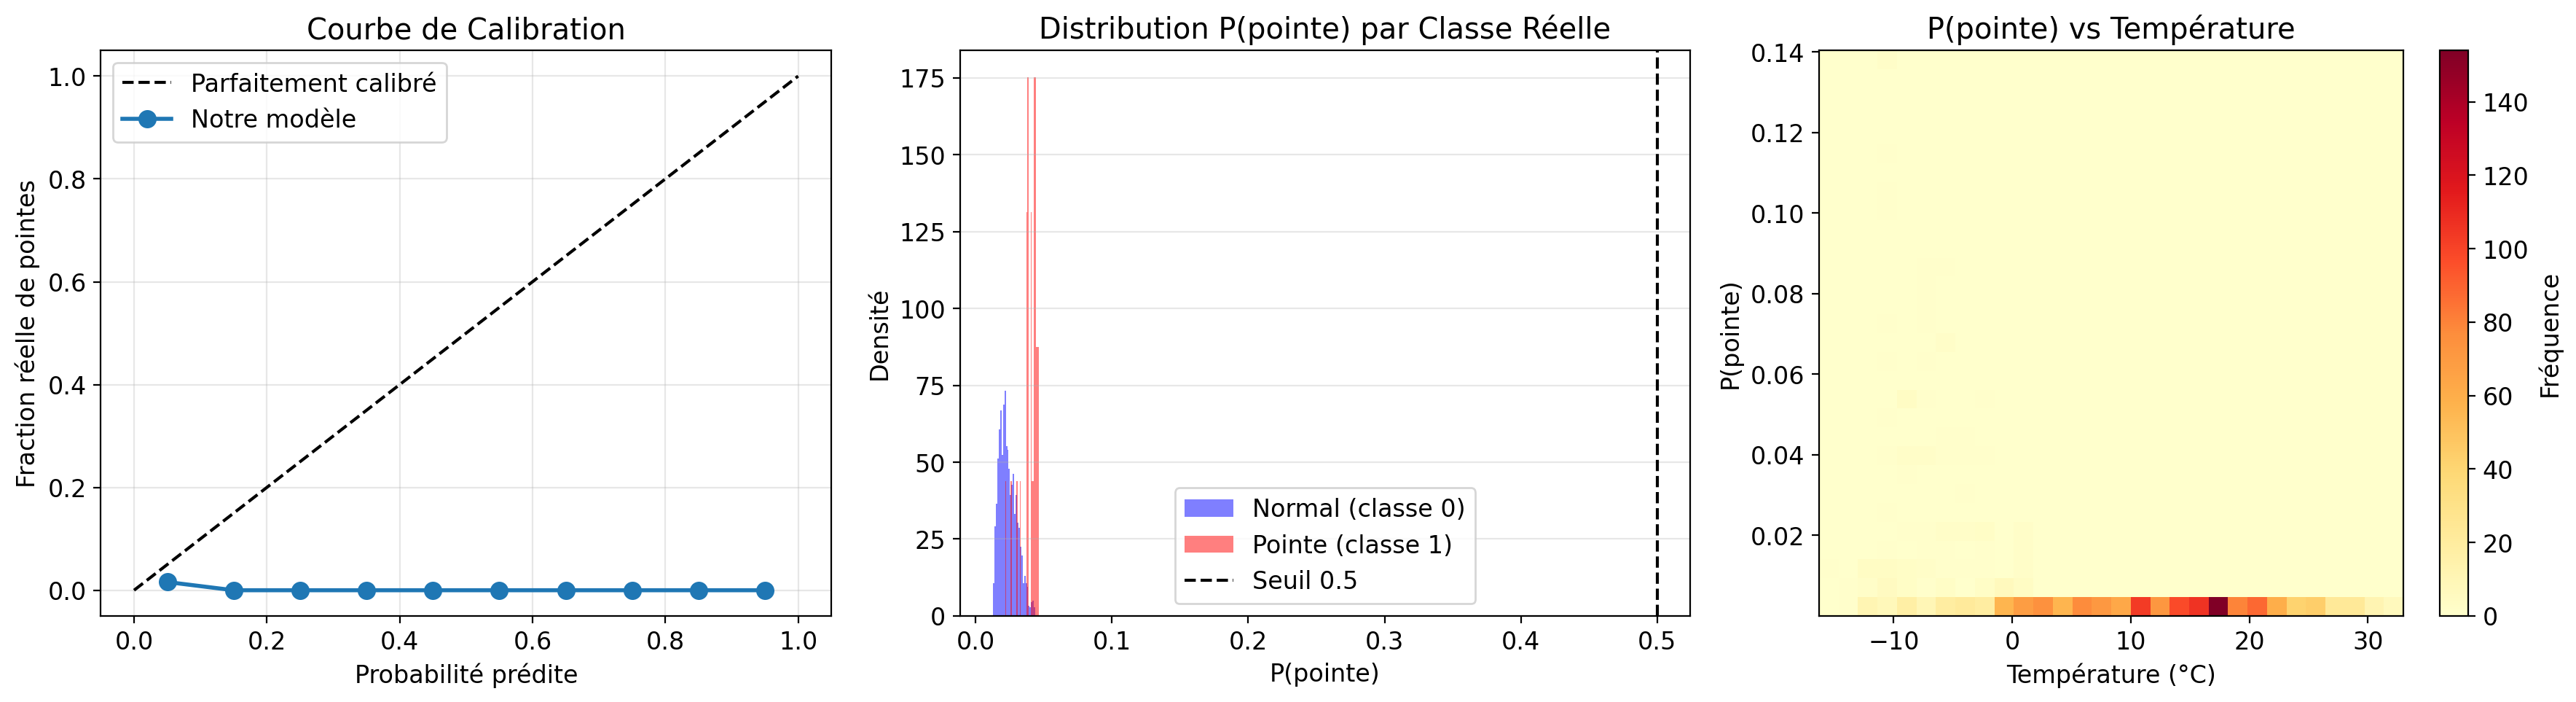


P(pointe) PAR SEGMENT

Train:
  Min:  0.000
  Q25:  0.000
  Médiane: 0.001
  Q75:  0.005
  Max:  0.714

Test:
  Min:  0.000
  Q25:  0.000
  Médiane: 0.000
  Q75:  0.000
  Max:  0.140

Pointe réelle:
  Min:  0.000
  Q25:  0.004
  Médiane: 0.010
  Q75:  0.065
  Max:  0.140

Normal réel:
  Min:  0.000
  Q25:  0.000
  Médiane: 0.000
  Q75:  0.000
  Max:  0.139


In [30]:
print("="*60)
print("ANALYSE CALIBRATION ET DISTRIBUTION P(pointe)")
print("="*60)

# 1. Calibration plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Diviser en bins de probabilité
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculer fraction réelle par bin
bin_indices = np.digitize(proba_test, bins) - 1
bin_indices = np.clip(bin_indices, 0, n_bins - 1)

fraction_positive = np.zeros(n_bins)
count_per_bin = np.zeros(n_bins)

for i in range(n_bins):
    mask = bin_indices == i
    if mask.sum() > 0:
        fraction_positive[i] = y_test_clf[mask].mean()
        count_per_bin[i] = mask.sum()

# Calibration curve
axes[0].plot([0, 1], [0, 1], 'k--', label='Parfaitement calibré')
axes[0].plot(bin_centers, fraction_positive, 'o-', linewidth=2,
            label='Notre modèle', markersize=8)
axes[0].set_xlabel('Probabilité prédite')
axes[0].set_ylabel('Fraction réelle de pointes')
axes[0].set_title('Courbe de Calibration')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution P(pointe) par classe réelle
axes[1].hist(proba_test[y_test_clf==0], bins=30, alpha=0.5,
            label='Normal (classe 0)', color='blue', density=True)
axes[1].hist(proba_test[y_test_clf==1], bins=30, alpha=0.5,
            label='Pointe (classe 1)', color='red', density=True)
axes[1].axvline(0.5, color='black', linestyle='--', label='Seuil 0.5')
axes[1].set_xlabel('P(pointe)')
axes[1].set_ylabel('Densité')
axes[1].set_title('Distribution P(pointe) par Classe Réelle')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Histogramme 2D
axes[2].hist2d(test_eng['temperature_ext'], test_eng['P_pointe'],
              bins=30, cmap='YlOrRd')
axes[2].set_xlabel('Température (°C)')
axes[2].set_ylabel('P(pointe)')
axes[2].set_title('P(pointe) vs Température')
plt.colorbar(axes[2].collections[0], ax=axes[2], label='Fréquence')

plt.tight_layout()
plt.show()

# 2. Analyse segmentée
print(f"\n{'='*60}")
print("P(pointe) PAR SEGMENT")
print("="*60)

segments = {
    'Train': train_eng['P_pointe'],
    'Test': test_eng['P_pointe'],
    'Pointe réelle': test_eng[test_eng['evenement_pointe']==1]['P_pointe'],
    'Normal réel': test_eng[test_eng['evenement_pointe']==0]['P_pointe']
}

for name, data in segments.items():
    print(f"\n{name}:")
    print(f"  Min:  {data.min():.3f}")
    print(f"  Q25:  {data.quantile(0.25):.3f}")
    print(f"  Médiane: {data.median():.3f}")
    print(f"  Q75:  {data.quantile(0.75):.3f}")
    print(f"  Max:  {data.max():.3f}")

---

## Partie 6: Modèle combiné (10%)

Assemblez le modèle final en ajoutant `P_pointe` comme caractéristique.

In [31]:
# Caractéristiques finales (avec P_pointe)
features_final = features_disponibles + ['P_pointe']

X_train_final = train_eng[features_final].values
y_train_final = train_eng['energie_kwh'].values
X_test_final = test_eng[features_final].values
y_test_final = test_eng['energie_kwh'].values

# Modèle Ridge final
model_final = RidgeCV(alphas=[0.1, 1, 10, 100], cv=TimeSeriesSplit(n_splits=5))
model_final.fit(X_train_final, y_train_final)
y_pred_final = model_final.predict(X_test_final)

print("Modèle final (Ridge + P_pointe):")
print(f"  λ sélectionné: {model_final.alpha_}")
print(f"  R² train: {model_final.score(X_train_final, y_train_final):.4f}")
print(f"  R² test:  {r2_score(y_test_final, y_pred_final):.4f}")
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_test_final, y_pred_final)):.4f}")

Modèle final (Ridge + P_pointe):
  λ sélectionné: 100.0
  R² train: 0.4728
  R² test:  0.3468
  RMSE test: 48.1820


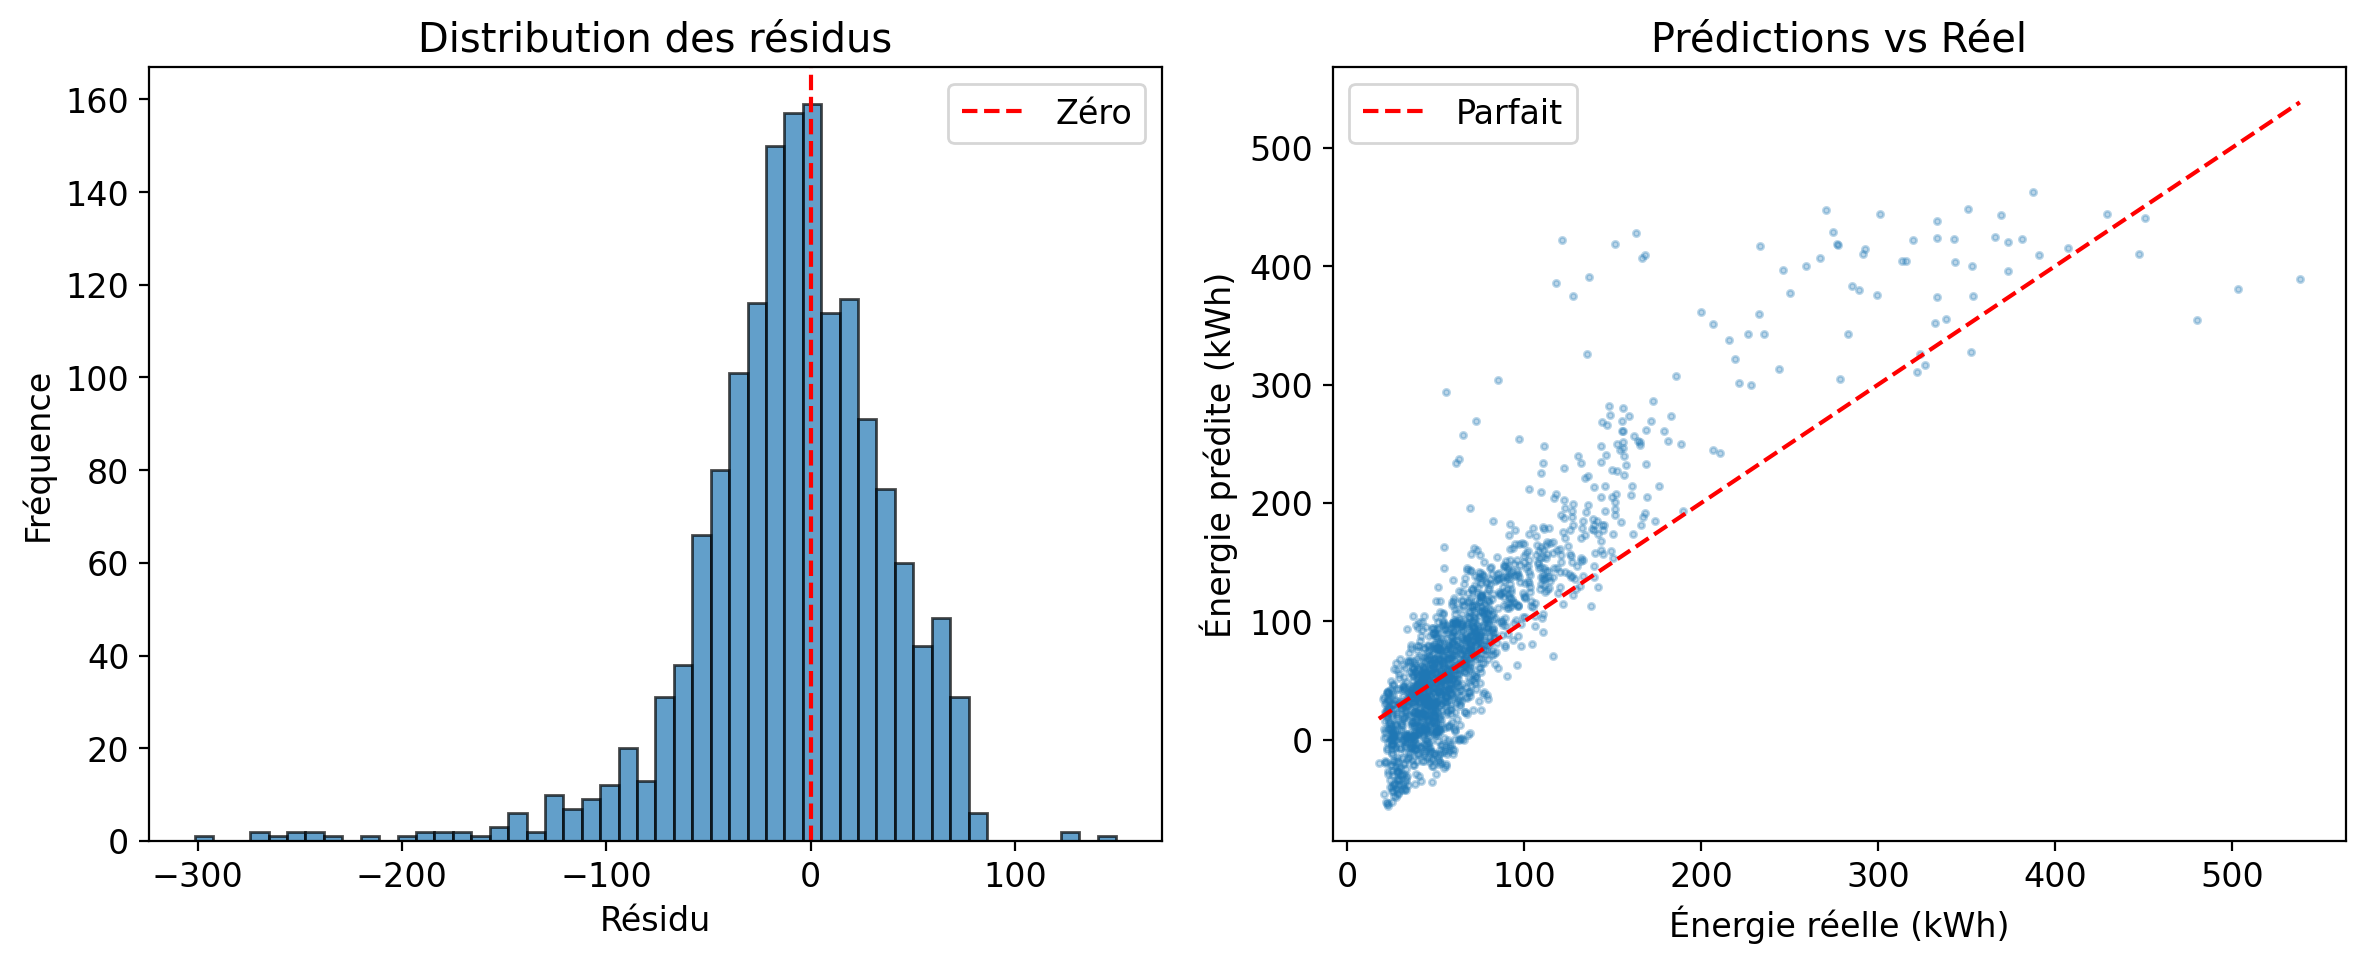

In [32]:
# Visualisation des résidus
residus = y_test_final - y_pred_final

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogramme des résidus
axes[0].hist(residus, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', label='Zéro')
axes[0].set_xlabel('Résidu')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des résidus')
axes[0].legend()

# Prédictions vs réel
axes[1].scatter(y_test_final, y_pred_final, alpha=0.3, s=5)
axes[1].plot([y_test_final.min(), y_test_final.max()], 
             [y_test_final.min(), y_test_final.max()], 'r--', label='Parfait')
axes[1].set_xlabel('Énergie réelle (kWh)')
axes[1].set_ylabel('Énergie prédite (kWh)')
axes[1].set_title('Prédictions vs Réel')
axes[1].legend()

plt.tight_layout()

ANALYSE APPROFONDIE DES ERREURS

Erreurs moyennes:
  Normal: 32.43 kWh
  Pointe: 193.62 kWh
  Ratio pointe/normal: 5.97x


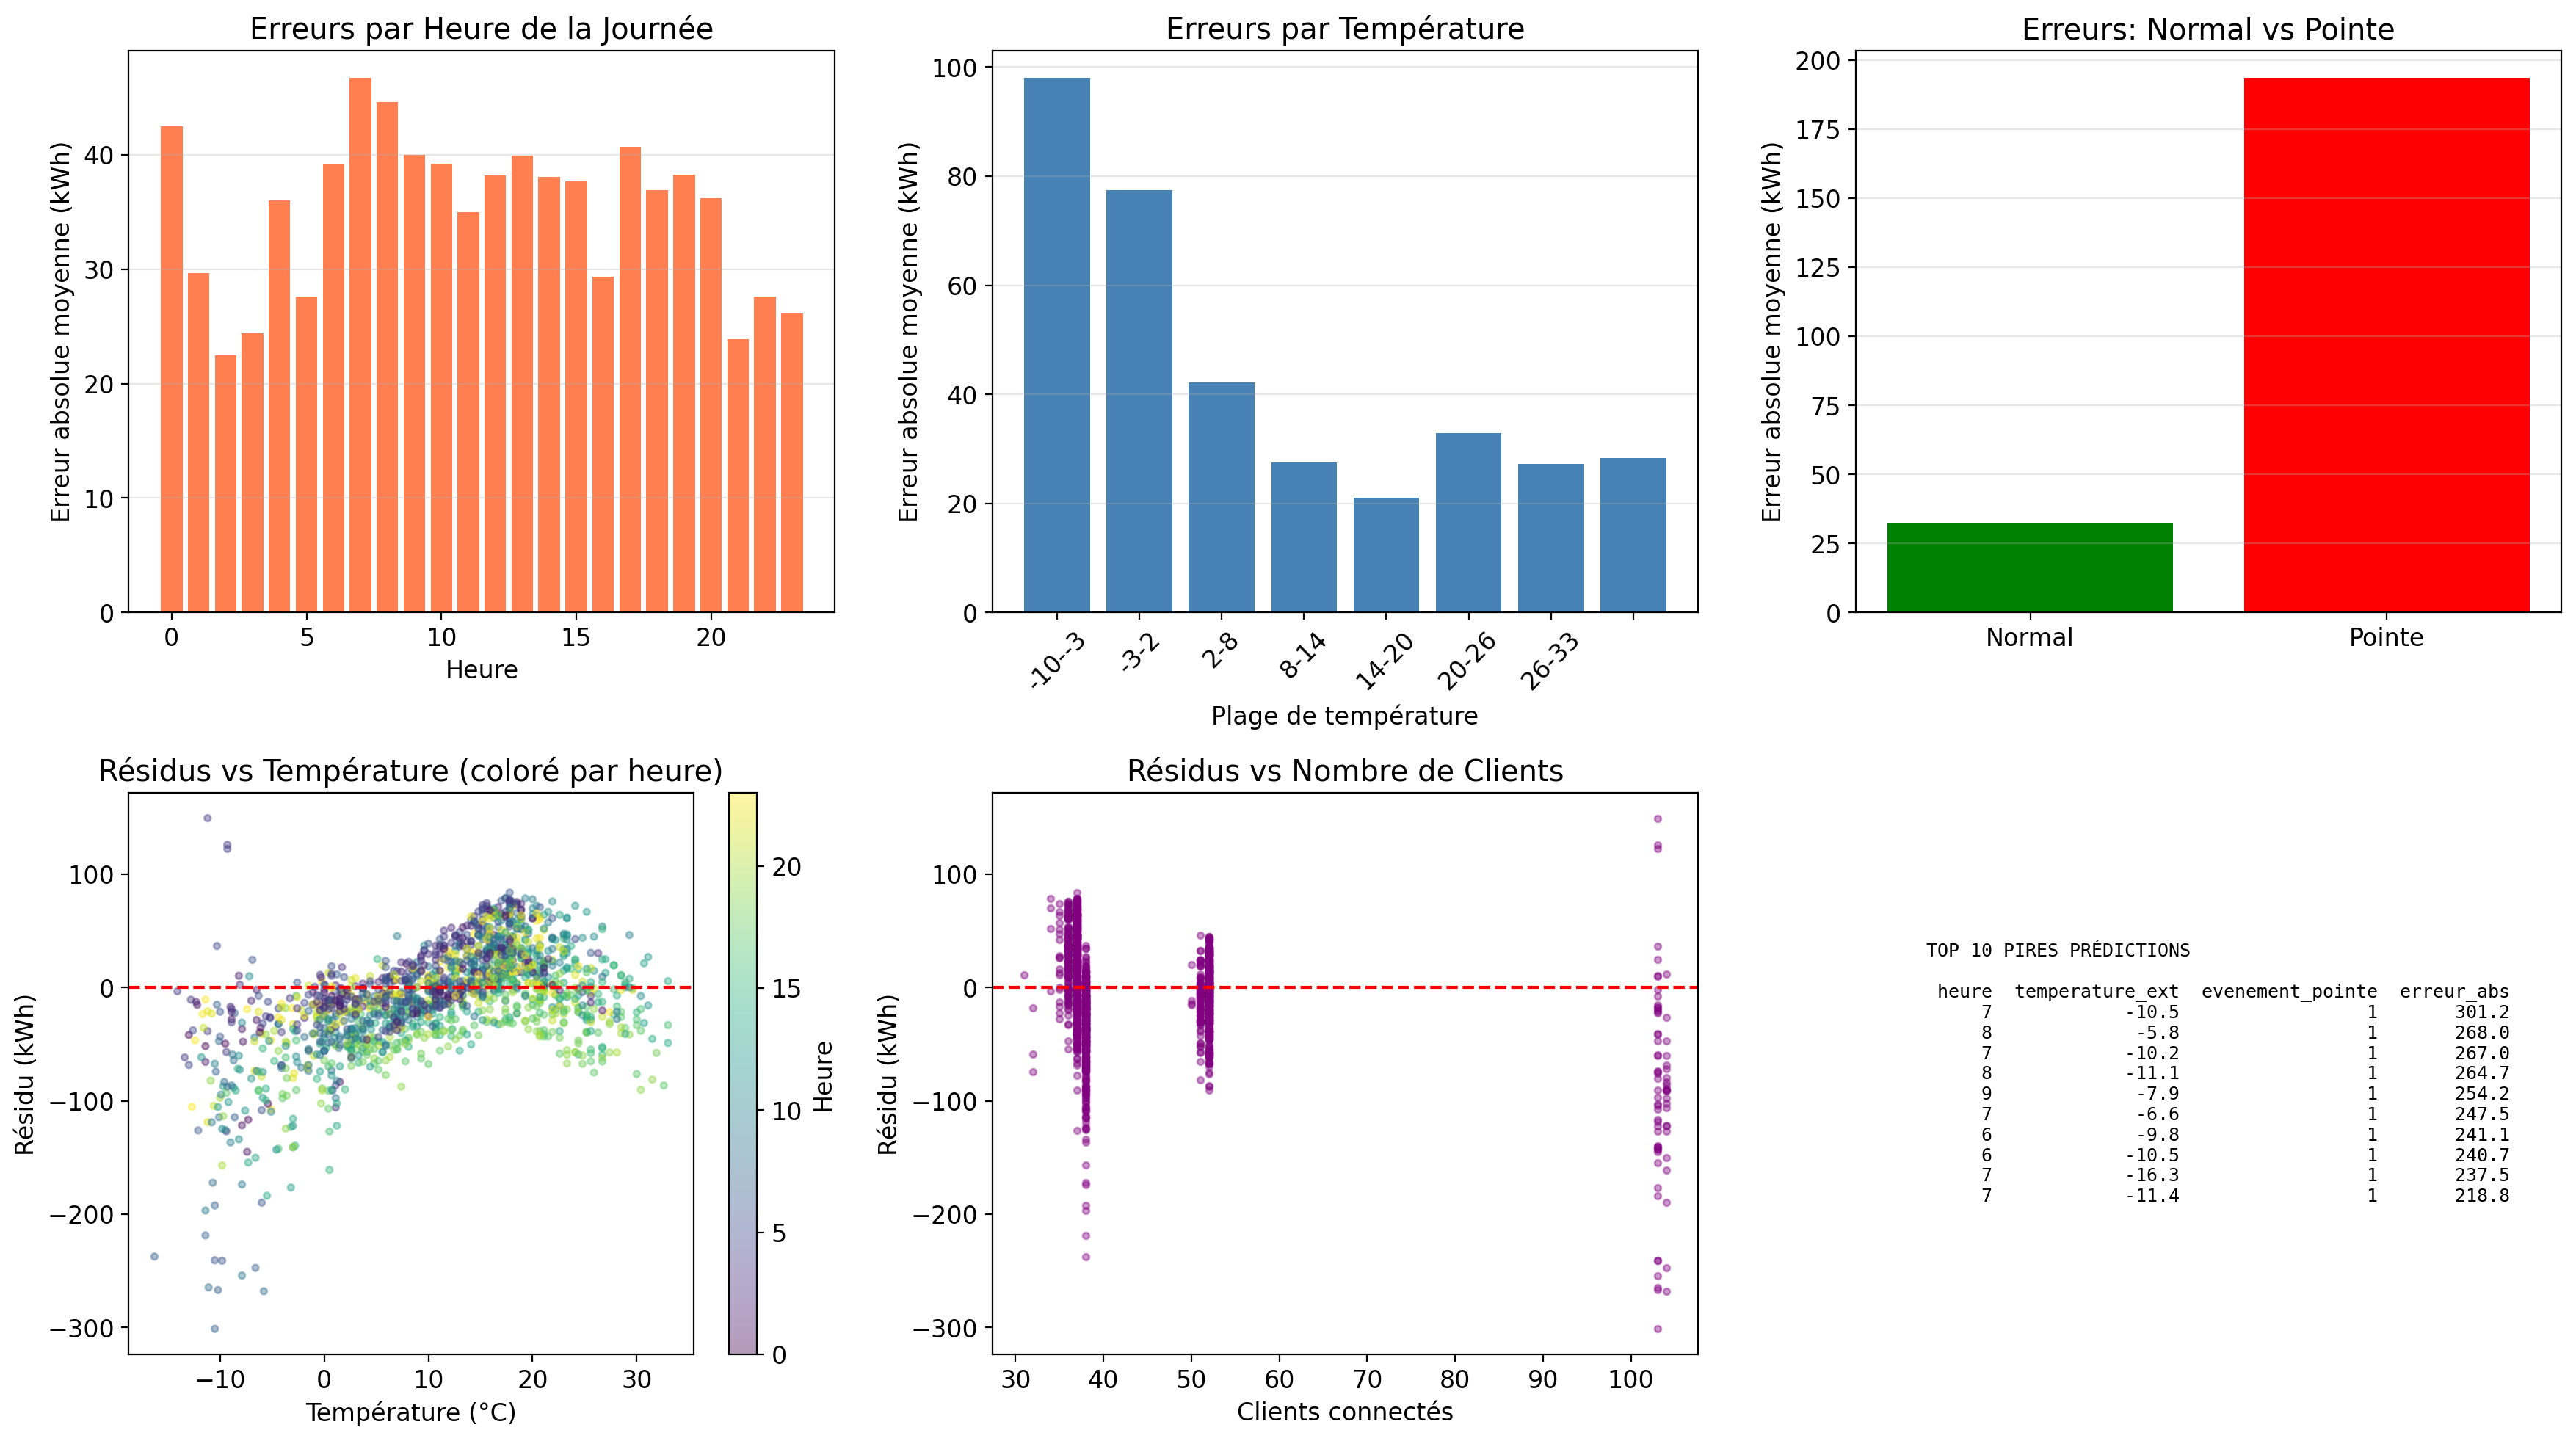


PERFORMANCE PAR NIVEAU DE CONSOMMATION


IndexError: index 1588 is out of bounds for axis 0 with size 1586

In [ ]:
print("="*60)
print("ANALYSE APPROFONDIE DES ERREURS")
print("="*60)
print("asdassadsad")

# 1. Erreurs par segment
residus_final = y_test_final - y_pred_final
test_analysis = test_eng.copy()
test_analysis['residus'] = residus_final
test_analysis['erreur_abs'] = np.abs(residus_final)
test_analysis['erreur_pct'] = 100 * np.abs(residus_final) / (y_test_final + 1)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Erreurs par heure
erreurs_heure = test_analysis.groupby('heure')['erreur_abs'].mean()
axes[0, 0].bar(erreurs_heure.index, erreurs_heure.values, color='coral')
axes[0, 0].set_xlabel('Heure')
axes[0, 0].set_ylabel('Erreur absolue moyenne (kWh)')
axes[0, 0].set_title('Erreurs par Heure de la Journée')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Erreurs par température
temp_bins = pd.cut(test_analysis['temperature_ext'], bins=8)
erreurs_temp = test_analysis.groupby(temp_bins)['erreur_abs'].mean()
axes[0, 1].bar(range(len(erreurs_temp)), erreurs_temp.values, color='steelblue')
axes[0, 1].set_xlabel('Plage de température')
axes[0, 1].set_ylabel('Erreur absolue moyenne (kWh)')
axes[0, 1].set_title('Erreurs par Température')
axes[0, 1].set_xticklabels([f"{int(i.left)}-{int(i.right)}" 
                             for i in erreurs_temp.index], rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Erreurs par type (pointe vs normal)
erreurs_type = test_analysis.groupby('evenement_pointe')['erreur_abs'].mean()
axes[0, 2].bar(['Normal', 'Pointe'], erreurs_type.values, color=['green', 'red'])
axes[0, 2].set_ylabel('Erreur absolue moyenne (kWh)')
axes[0, 2].set_title('Erreurs: Normal vs Pointe')
axes[0, 2].grid(True, alpha=0.3, axis='y')

print(f"\nErreurs moyennes:")
print(f"  Normal: {erreurs_type[0]:.2f} kWh")
print(f"  Pointe: {erreurs_type[1]:.2f} kWh")
print(f"  Ratio pointe/normal: {erreurs_type[1]/erreurs_type[0]:.2f}x")

# Résidus vs features importantes
axes[1, 0].scatter(test_analysis['temperature_ext'], residus_final, 
                   alpha=0.4, s=10, c=test_analysis['heure'], cmap='viridis')
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Température (°C)')
axes[1, 0].set_ylabel('Résidu (kWh)')
axes[1, 0].set_title('Résidus vs Température (coloré par heure)')
plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Heure')

axes[1, 1].scatter(test_analysis['clients_connectes'], residus_final,
                   alpha=0.4, s=10, color='purple')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Clients connectés')
axes[1, 1].set_ylabel('Résidu (kWh)')
axes[1, 1].set_title('Résidus vs Nombre de Clients')

# Top 10 pires prédictions
axes[1, 2].axis('off')
pires = test_analysis.nlargest(10, 'erreur_abs')[
    ['heure', 'temperature_ext', 'evenement_pointe', 'erreur_abs']
]
table_text = "TOP 10 PIRES PRÉDICTIONS\n\n"
table_text += pires.to_string(index=False, float_format='%.1f')
axes[1, 2].text(0.1, 0.5, table_text, fontsize=9, 
                family='monospace', verticalalignment='center')

plt.tight_layout()
plt.show()

# 2. Métriques par quantile de consommation
print(f"\n{'='*60}")
print("PERFORMANCE PAR NIVEAU DE CONSOMMATION")
print("="*60)

test_analysis['consommation_level'] = pd.qcut(y_test_final, q=4,
                                               labels=['Faible', 'Moyen', 'Élevé', 'Très élevé'])

perf_by_level = test_analysis.groupby('consommation_level').agg({
    'erreur_abs': 'mean',
    'erreur_pct': 'mean',
    'residus': lambda x: r2_score(y_test_final[x.index], 
                                   y_pred_final[x.index])
}).round(2)
perf_by_level.columns = ['MAE (kWh)', 'MAPE (%)', 'R²']

print(perf_by_level)

print("\nConstat: Le modèle est-il meilleur sur certaines plages?")

---

## Partie 7: Extension (10%) - Choisir UNE option

### Option A: Données météorologiques externes
Utilisez la bibliothèque `meteostat` pour ajouter des données météo supplémentaires (ex: pression atmosphérique, point de rosée).

### Option B: Classification multiclasse
Au lieu de binaire (pointe/normal), créez 3+ classes de consommation (faible/moyenne/élevée) et utilisez softmax.

### Option C: Analyse d'erreur approfondie
Identifiez quand le modèle fait le plus d'erreurs et proposez des améliorations.

In [ ]:
# VOTRE EXTENSION ICI
# Indiquez quelle option vous avez choisie et pourquoi.

# Option choisie: ___
# Justification: ___

---

## Soumission Kaggle

Générez votre fichier de soumission pour la compétition.

In [ ]:
# Générer les prédictions pour Kaggle (sur test_kaggle, sans la cible)
# Note: utilisez votre meilleur modèle pour faire ces prédictions
# Exemple avec le modèle final:
# X_kaggle = test_kaggle[features_final].values
# y_pred_kaggle = votre_modele.predict(X_kaggle)

submission = pd.DataFrame({
    'id': range(len(test_kaggle)),
    'energie_kwh': y_pred_final  # Remplacez par vos prédictions sur test_kaggle
})

submission.to_csv('submission.csv', index=False)
print(f"Fichier de soumission créé: submission.csv ({len(submission)} lignes)")
submission.head()

---

## Questions de préparation pour l'entrevue orale

Préparez-vous à répondre à ces questions:

### Fondamentaux
test_analysis['y_true'] = y_test_final
test_analysis['y_pred'] = y_pred_final
test_analysis['residus'] = residus_final
test_analysis['erreur_abs'] = np.abs(residus_final)
test_analysis['erreur_pct'] = 100 * np.abs(residus_final) / (y_test_final + 1)
4. Pourquoi Ridge aide-t-il avec des caractéristiques corrélées?
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Erreurs par heure
erreurs_heure = test_analysis.groupby('heure')['erreur_abs'].mean()
axes[0, 0].bar(erreurs_heure.index, erreurs_heure.values, color='coral')
axes[0, 0].set_xlabel('Heure')
axes[0, 0].set_ylabel('Erreur absolue moyenne (kWh)')
axes[0, 0].set_title('Erreurs par Heure de la Journée')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Erreurs par température
temp_bins = pd.cut(test_analysis['temperature_ext'], bins=8)
erreurs_temp = test_analysis.groupby(temp_bins)['erreur_abs'].mean()
axes[0, 1].bar(range(len(erreurs_temp)), erreurs_temp.values, color='steelblue')
axes[0, 1].set_xlabel('Plage de température')
axes[0, 1].set_ylabel('Erreur absolue moyenne (kWh)')axes[0, 1].set_title('Erreurs par Température')axes[0, 1].set_xticklabels([f"{int(i.left)}-{int(i.right)}"                              for i in erreurs_temp.index], rotation=45)axes[0, 1].grid(True, alpha=0.3, axis='y')# Erreurs par type (pointe vs normal)erreurs_type = test_analysis.groupby('evenement_pointe')['erreur_abs'].mean()axes[0, 2].bar(['Normal', 'Pointe'], erreurs_type.values, color=['green', 'red'])axes[0, 2].set_ylabel('Erreur absolue moyenne (kWh)')axes[0, 2].set_title('Erreurs: Normal vs Pointe')axes[0, 2].grid(True, alpha=0.3, axis='y')print(f"\nErreurs moyennes:")print(f"  Normal: {erreurs_type[0]:.2f} kWh")print(f"  Pointe: {erreurs_type[1]:.2f} kWh")print(f"  Ratio pointe/normal: {erreurs_type[1]/erreurs_type[0]:.2f}x")# Résidus vs features importantesaxes[1, 0].scatter(test_analysis['temperature_ext'], residus_final,                    alpha=0.4, s=10, c=test_analysis['heure'], cmap='viridis')axes[1, 0].axhline(0, color='red', linestyle='--')axes[1, 0].set_xlabel('Température (°C)')axes[1, 0].set_ylabel('Résidu (kWh)')axes[1, 0].set_title('Résidus vs Température (coloré par heure)')plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Heure')axes[1, 1].scatter(test_analysis['clients_connectes'], residus_final,                   alpha=0.4, s=10, color='purple')axes[1, 1].axhline(0, color='red', linestyle='--')axes[1, 1].set_xlabel('Clients connectés')axes[1, 1].set_ylabel('Résidu (kWh)')axes[1, 1].set_title('Résidus vs Nombre de Clients')# Top 10 pires prédictionsaxes[1, 2].axis('off')pires = test_analysis.nlargest(10, 'erreur_abs')[    ['heure', 'temperature_ext', 'evenement_pointe', 'erreur_abs']]table_text = "TOP 10 PIRES PRÉDICTIONS\n\n"table_text += pires.to_string(index=False, float_format='%.1f')axes[1, 2].text(0.1, 0.5, table_text, fontsize=9,                 family='monospace', verticalalignment='center')plt.tight_layout()plt.show()# 2. Métriques par quantile de consommationprint(f"\n{'='*60}")print("PERFORMANCE PAR NIVEAU DE CONSOMMATION")print("="*60)test_analysis['consommation_level'] = pd.qcut(y_test_final, q=4,                                               labels=['Faible', 'Moyen', 'Élevé', 'Très élevé'])perf_by_level = test_analysis.groupby('consommation_level').agg({    'erreur_abs': 'mean',    'erreur_pct': 'mean',    'residus': lambda x: r2_score(y_test_final[x.index],                                    y_pred_final[x.index])}).round(2)perf_by_level.columns = ['MAE (kWh)', 'MAPE (%)', 'R²']print(perf_by_level)

print("\nConstat: Le modèle est-il meilleur sur certaines plages?")